In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
# substitute for your own DiffSci path
os.chdir('c:\\Users\\bepsc\\OneDrive\\Documentos\\GitHub\\DiffSci')

In [4]:
import math
from scipy.stats import wasserstein_distance, entropy
import pathlib
import re
from scipy import integrate
import itertools
import diffsci.data
import diffsci.models

Mean: -0.011137143708765507
std: 0.3503609895706177


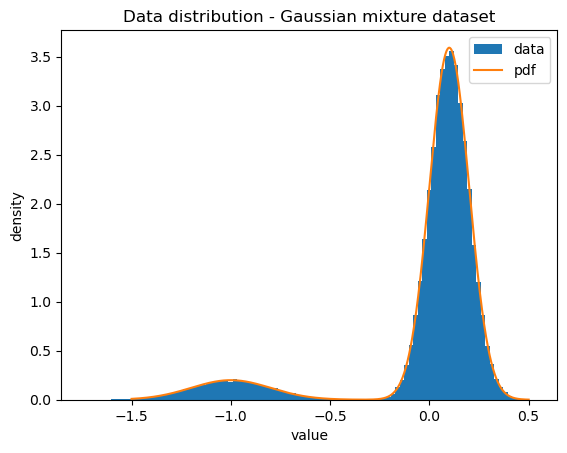

In [5]:
# Define Gaussian mixture dataset
points = torch.tensor([-1,0.1]).unsqueeze(-1)
weights = torch.tensor([0.1,0.9])
scale = torch.tensor([0.2,0.1])
nsamples = 100000
gaussian_dataset2 = diffsci.data.MixtureOfGaussiansDataset(num_samples=nsamples, means=points, weights=weights, scale=scale) 
gaussian_samples2 = gaussian_dataset2.sample()

# compute mean and std
mean = gaussian_samples2.mean()
std = gaussian_samples2.std()
print(f'Mean: {mean}')
print(f'std: {std}')

# Plot the sampled distribution
bins = 100
plt.hist(gaussian_samples2.squeeze(-1), bins=bins, density=True, label='data')
plt.title("Data distribution - Gaussian mixture dataset")
plt.ylabel("density")
plt.xlabel("value")

# plot pdf
x = torch.linspace(-1.5, 0.5, 1000).unsqueeze(-1)
sigma = torch.zeros_like(x[..., 0])
pdf = gaussian_dataset2.prob(x, sigma)
plt.plot(x, pdf, label='pdf')
plt.legend()

Text(0.5, 1.0, 'Score function - Gaussian mixture dataset')

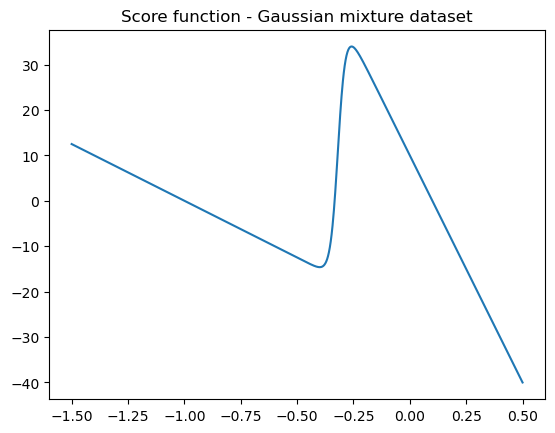

In [6]:
# plot score function
score = gaussian_dataset2.gradlogprob(x, sigma)
plt.plot(x, score, label='score function ')
plt.title("Score function - Gaussian mixture dataset")

Define all functions

In [7]:
# define diffusion prior
def prior_pdf(x, sigma):
    expterm = -0.5 * x**2 / sigma**2
    normalizer = 1/(np.sqrt(2*math.pi)*sigma)
    return normalizer * torch.exp(expterm)

# compute relative entropy for an aligned pair of densities (p, q) and a grid x
def relative_entropy(p, q, x, epsilon = 1e-15):
    # Avoid division by zero and log of zero
    p_values = torch.clip(p, epsilon, None)
    q_values = torch.clip(q, epsilon, None)

    x_size = abs(x[1] - x[0])
    dx = x_size.item()
    kl_divergence = torch.trapezoid(p_values * torch.log(p_values / q_values), dx=dx, dim=0)
    return kl_divergence

# standard way to format variables
def formatted(variable):
    if variable < 1e-3:
        formatted_variable = f'{variable:.2e}'
        formatted_variable = re.sub(r'e([-+]?)(\d+)', r' \\times 10^{\1\2}', formatted_variable)
    else:
        formatted_variable = f'{variable:.4f}'
    return formatted_variable

# compute the analytic entropy

def analytical_initial_entropy(dataset, initial_time, scheduler = diffsci.models.EDMScheduler(),
                               xlim = 3, ngrid =10000, plot = False, return_pdf=False, process = 'edm',
                               fontsize = 14, inverseH = False, ylim = None):
    sigma = scheduler.scheduler_fns.noise_fn(torch.tensor(initial_time))
    scale = scheduler.scheduler_fns.scaling_fn(torch.tensor(initial_time))
    s = torch.tensor(sigma*scale)
    x = torch.linspace(-xlim, xlim,ngrid)
    x_ = x.unsqueeze(-1)
    p = prior_pdf(x_, s)
    q = dataset.prob(x_, sigma.unsqueeze(-1), scale.unsqueeze(-1))
    q = q.unsqueeze(-1)
    if inverseH:
        entropy = relative_entropy(q, p, x).item()
    else:
        entropy = relative_entropy(p, q, x).item()
    if plot:
        plt.plot(x, p, label='approx prior pdf')
        plt.plot(x, q, label='true prior pdf')
        plt.legend(fontsize=fontsize)
        if ylim is not None:
            plt.ylim(0, ylim)
        plt.title(f'Distributions at $t = {initial_time:.2f}$ ({process.upper()})', fontsize=fontsize+2)
        # Add a text box
        formatted_entropy = formatted(entropy)
        if inverseH:
            textstr = f'$H(p|\~p) = {formatted_entropy}$'
        else:
            textstr = f'Entropy value:\n$H_{{init}} = {formatted_entropy}$'
        plt.gca().text(0.025, 0.75, textstr, transform=plt.gca().transAxes, fontsize=fontsize,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        plt.show()
    if return_pdf:
        return entropy, p, q, x
    else:
        return entropy

In [8]:
def approx_entropy(samples1, samples2, samples_ref, epsilon=1e-12, nbins=100, mean = True,
                   inverseH = False):
    entropies1 = []
    entropies2 = []
    for nb in range(nbins-20, nbins):
        if nb%4 == 0:
            continue
        min_value = torch.min(torch.tensor([samples1.min(), samples2.min(), samples_ref.min()]))
        max_value = torch.max(torch.tensor([samples1.max(), samples2.max(), samples_ref.max()]))
        dist = []
        bins = np.linspace(min_value, max_value, nb)
        for samples in [samples1, samples2, samples_ref]:
            hist = np.histogram(samples, bins=bins, density=True)[0]
            dist.append(hist+epsilon)
        if inverseH:
            entropy1 = entropy(dist[2], dist[0])
            entropy2 = entropy(dist[2], dist[1])
        else:
            entropy1 = entropy(dist[0], dist[2])
            entropy2 = entropy(dist[1], dist[2])
        entropies1.append(entropy1)
        entropies2.append(entropy2)
    if mean:
        entropy1 = np.mean(entropies1)
        entropy2 = np.mean(entropies2)
    else:
        entropy1 = np.min(entropies1)
        entropy2 = np.min(entropies2)
    return entropy1, entropy2

def approx_entropy1(samples,samples_ref, epsilon=1e-12, nbins=100):
    min_value = torch.min(torch.tensor([samples.min(), samples_ref.min()]))
    max_value = torch.max(torch.tensor([samples.max(), samples_ref.max()]))
    dist = []
    bins = np.linspace(min_value, max_value, nbins)
    for samples in [samples, samples_ref]:
        hist = np.histogram(samples, bins=bins, density=True)[0]
        dist.append(hist+epsilon)
    entropy1 = entropy(dist[0], dist[1])
    return entropy1

In [9]:
# substitute for your own paths

def path_from_datatype(datatype, figure=False):
    if datatype == 'gaussian':
        path = pathlib.Path('C:/Users/bepsc/OneDrive/Documentos/GitHub/DiffSci/outputdata/bps/entropy_paper/gaussian')
    elif datatype == 'gaussian2':
        path = pathlib.Path('C:/Users/bepsc/OneDrive/Documentos/GitHub/DiffSci/outputdata/bps/entropy_paper/gaussian2')
    elif datatype == 'uniform':
        path = pathlib.Path('C:/Users/bepsc/OneDrive/Documentos/GitHub/DiffSci/outputdata/bps/entropy_paper/uniform')
    else:
        raise ValueError('Invalid datatype')
    if figure:
        path = path / 'figures'
    return path

In [10]:
def generate_samples(initial_step, gamma, nsteps, nsamples, dataset, datatype,
                     initial_p, exact_p,
                     interval=None,
                     sample_type='ode',
                     noisescheduler=diffsci.models.EDMScheduler(sigma_max=10),
                     scheduler_type= 'edm',
                     module=None,
                     use_exact_prior=False,
                     return_history=True,
                     checkpoint=None,
                     save_samples=True,
                     interp_fn = None,
                     integrator=diffsci.models.EulerIntegrator()):
    print(f'NoiseScheduler: {noisescheduler}')
    # set noise scheduler
    noisescheduler._integrator = integrator
    noisescheduler.langevin_const = gamma
    noisescheduler.langevin_interval = interval
    if module is not None:
        module.config.noisescheduler = noisescheduler
    
    # obtain initial time from initial step
    time = noisescheduler.create_steps(nsteps+1)
    initial_time_ = time[initial_step]
    initial_time = initial_time_.item() 

    prior_ = initial_p.squeeze(-1)
    exact_prior_ = exact_p.squeeze(-1)

    # plot prior distributions
    nbins = 100
    xlim = 5*sigma
    exact_initial_entropy, approx_dens, exact_dens, x = analytical_initial_entropy(
        dataset, initial_time, scheduler=noisescheduler, plot = False, return_pdf=True, xlim=xlim)
    print(f'Exact initial entropy = {exact_initial_entropy:.5f}')

    fig, ax = plt.subplots(1,2,figsize=(12,5))
    ax[0].hist(prior_, bins=nbins, density=True, alpha=0.5, label='independent prior', color='brown')
    ax[0].hist(exact_prior_, bins=nbins, density=True, alpha=0.5, color='green', label='exact prior')
    ax[0].set_title(f'Samples at time T={initial_time:.2f}')
    ax[0].xlim = xlim
    ax[0].legend()
    ax[1].plot(x, exact_dens, label='exact prior pdf')
    ax[1].plot(x, approx_dens, label='independent prior pdf')
    ax[1].set_title(f'Densities at time T={initial_time:.2f}')
    ax[1].legend()
    # text box
    formatted_intial_entropy = formatted(exact_initial_entropy)
    textstr = f'Entropy value:\n$H_{{init}} = {formatted_intial_entropy}$'
    ax[1].text(0.025, 0.95, textstr, transform=ax[1].transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.show()

    # backward integration
    if use_exact_prior:
        prior = exact_p
    else:
        prior = initial_p
    
    if sample_type == 'ode':
        stochastic = False
    elif sample_type == 'sde':
        stochastic = True
        integrator = diffsci.models.EulerMaruyamaIntegrator()
    else:
        raise ValueError('Invalid sample_type')
    
    if module is not None:
        print('Sampling with learned scores, device: ', module.device)
        prior = prior.to(module.device)
        sample_history = module.propagate_partial_toward_sample(
             prior, initial_step=initial_step, nsteps=nsteps, record_history=True, integrator=integrator,
             analytical_score=dataset.gradlogprob, interp_fn=interp_fn)
        sample_history = sample_history.cpu()
    else:
        sample_history = noisescheduler.propagate_partial(
            prior, dataset.gradlogprob, nsteps, initial_step=initial_step, final_step=nsteps,
            record_history=True, stochastic=stochastic)
    
    # plot trajectory
    time = noisescheduler.create_steps(nsteps+1)
    trunc_time = time[initial_step:]
    nplot = 300
    fig = plt.figure(figsize=(8, 6))
    for i in range(nplot):
        x = sample_history[:, i].squeeze()
        plt.plot(trunc_time, x, color='black', linestyle='-', alpha=0.1)
    plt.xlabel("diffusion time", fontsize=14)
    plt.ylabel("value", fontsize=14)
    # plt.xlim([0, 1])
    plt.ylim([-3, 3])
    if sample_type == 'ode':
        plt.title(f'ODE trajectories ({scheduler_type.upper()})', fontsize=16)
    else:
        plt.title(f'SDE trajectories ($\gamma = {gamma}$)', fontsize=16)
    plt.show()

    if return_history:
        samples = sample_history.squeeze(-1)
    else:
        samples = sample_history[-1].squeeze(-1)

    # save data
    if save_samples:
        if module is not None:
            if checkpoint is None:
                raise ValueError('Checkpoint is required')
            path = pathlib.Path(checkpoint).parent.parent / 'saved_samples'
        else:
            path = path_from_datatype(datatype)
        path.mkdir(exist_ok=True)
        
        filename = f'nsamples={nsamples:.0e}-nsteps={nsteps}-T={initial_time:.3f}'
        if module is not None:
            filename = 'tr-' + filename
        else:
            filename = 'an-' + filename
        if use_exact_prior:
            filename = f'{sample_type}-exact_prior-' + filename
        else:
            filename = f'{sample_type}-indep_prior-' + filename
        if sample_type == 'sde':
            if interval is not None:
                filename += f'-g={gamma}-int={interval}'
            else:
                filename += f'-g={gamma}'
        if interp_fn is not None:
            filename += '-interp'
        
        if return_history:
            filename += '-his'            
        if scheduler_type == 'edm':
            filename += '-EDM'
        elif scheduler_type == 'vp':
            filename += '-VP'
        elif scheduler_type == 've':
            filename += '-VE'
        else:
            raise ValueError('Invalid scheduler_type')
        
        print(f'Saving samples to {path / filename}')
        torch.save(samples, path / filename)
    return samples

In [11]:
def plot_figure(samples_ode, samples_sde, data, nsamples, nsteps, gamma, initial_time, datatype,
                initial_entropy=0, bound=None,
                nbins=100, title='Approximate prior and analytic scores',
                return_wasserstein=False, figname='approx_prior-analytic',fontsize=14, savefig=True):
    # compute entropy
    ode_entropy, sde_entropy = approx_entropy(samples_ode, samples_sde, data, nbins=nbins)

    # wasserstein distance
    ode_wdistance = wasserstein_distance(samples_ode, data)
    sde_wdistance = wasserstein_distance(samples_sde, data)

    # plot
    fig = plt.figure(figsize=(8, 6))
    plt.hist(samples_ode, bins=nbins, density=True, alpha=0.5, label='ODE')
    plt.hist(samples_sde, bins=nbins, density=True, alpha=0.5, label=f'SDE ($\\gamma = {gamma:.1f}$)')
    plt.hist(data, bins=nbins, density=True, histtype='step', color='black', label='data')
    plt.ylabel("density", fontsize=fontsize)
    # plt.xlim(-1, 1)
    plt.legend(fontsize=fontsize)
    plt.title(title + f', $T={initial_time:.2f}$',fontsize=fontsize+2)

    # Add a text box
    if initial_entropy !=0:
        formatted_initial_entropy = formatted(initial_entropy)
        textstr = f'Entropy values:\n$H_{{init}} = {formatted_initial_entropy}$ \n$H_{{ODE}} = {ode_entropy:.4f}$ \n$H_{{SDE}} = {sde_entropy:.4f}$ \n ($n_{{bins}} = {nbins}$)'
        # textstr = f'Entropy values:\n$H_{{init}} = {formatted_initial_entropy}$ \n$H_{{ODE}} = {ode_entropy:.4f}$ \n$H_{{SDE}} = {sde_entropy:.4f}$'
    else:
        textstr = f'Entropy values:\n$H_{{ODE}} = {ode_entropy:.4f}$ \n$H_{{SDE}} = {sde_entropy:.4f}$ \n ($n_{{bins}} = {nbins}$)'
        # textstr = f'Entropy values:\n$H_{{ODE}} = {ode_entropy:.4f}$ \n$H_{{SDE}} = {sde_entropy:.4f}$'
    if bound is not None and bound != 0:
        textstr += f'\n \n bound: {bound:.4f}'
    plt.gca().text(0.025, 0.65, textstr, transform=plt.gca().transAxes, fontsize=fontsize,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # save figure
    if savefig:
        path = path_from_datatype(datatype, figure=True)
        path.mkdir(exist_ok=True)
        figure_name = figname + f'-nsamples={nsamples:.0e}-nsteps={nsteps}-g={gamma}-T={initial_time:.2f}.png'
        fig.savefig(path / figure_name)
    if return_wasserstein:
        return ode_wdistance, sde_wdistance
    else:
        return None

In [12]:
def compute_entropy_evolution(ode_history, sde_history, diffused_history, time,  mean=True, nbins=100,
                              inverseH=False):

    ode_entropies = []
    sde_entropies = []
    ode_wdistances = []
    sde_wdistances = []
    nsteps = time.shape[0]
    for i in range(nsteps):
        ode_entropy, sde_entropy = approx_entropy(ode_history[i], sde_history[i], diffused_history[i],
                                                  nbins=nbins, mean=mean, inverseH=inverseH)
        ode_entropies.append(ode_entropy)
        sde_entropies.append(sde_entropy)
    return ode_entropies, sde_entropies

def plot_entropy_evolution(ode_entropies, sde_entropies, time, nsamples, gamma, initial_time, nsteps,
                           datatype, interval=None, initial_entropy=None,
                           bound_history=None,  # example: [[bound_his, delta], ...]
                           exact_score=False,
                           invH=False,
                           nbins=100,
                           title='Entropy evolution, approximate prior and analytic scores',
                           figname='stats_evolution-approx_prior-analytic',
                           x_logscale=False, y_logscale=False, ylim=None, fontsize=14):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(time, ode_entropies, label='ODE')
    plt.plot(time, sde_entropies, label=f'SDE ($\\gamma = {gamma:.1f}$)')
    if bound_history is not None:
        if exact_score or invH:
            plt.plot(time, bound_history, label='bound (SDE)', linestyle='--')
        else:
            for bound in bound_history:
                plt.plot(time, bound[0], label=f'bound (SDE), d={bound[1]}', linestyle='--')
    if initial_entropy != 0:
        plt.hlines(initial_entropy, 0, initial_time, label='initial entropy', linestyle='-.')
    plt.xlabel("diffusion time", fontsize=fontsize)
    plt.ylabel(f"entropy values ($n_{{bins}}={nbins}$)", fontsize=fontsize)
    if x_logscale:
        plt.xscale('log')
    if y_logscale:
        plt.yscale('log')
    if ylim is not None:
        plt.ylim(0, ylim)
    plt.legend(fontsize=fontsize)
    plt.title(title,fontsize=fontsize+2)
    plt.tight_layout()

    # save figure
    path = path_from_datatype(datatype, figure=True)
    path.mkdir(exist_ok=True)
    figure_name = figname + f'-nsamples={nsamples:.0e}-nsteps={nsteps}-T={initial_time:.3f}-g={gamma}'
    if interval is not None:
        figure_name += f'-{interval}'
    if x_logscale:
        figure_name += '-xlog'
    if y_logscale:
        figure_name += '-ylog'
    figure_name +='.png'
    fig.savefig(path / figure_name)
    return None

In [13]:
def custom_spacing(min, max, N, alpha):
    min_alpha = min ** alpha
    max_alpha = max ** alpha
    lin_space = torch.linspace(min_alpha, max_alpha, N)
    gamma_values = lin_space ** (1 / alpha)
    return gamma_values

def generate_multiple_gamma(initial_step, gamma_range, nsteps, nsamples, dataset, datatype,
                            ngamma=20,
                            interval=None,
                            noisescheduler=diffsci.models.EDMScheduler(sigma_max=10),
                            module=None,
                            use_exact_prior=False,
                            return_history=True,
                            checkpoint=None,
                            alpha=0.5):
    # set noise scheduler
    noisescheduler._integrator = diffsci.models.EulerIntegrator()
    noisescheduler.langevin_interval = interval
    if module is not None:
        module.config.noisescheduler = noisescheduler
    
    # hack to obtain step from initial_time
    time = noisescheduler.create_steps(nsteps+1)
    initial_time = time[initial_step].item()
    print(f'Initial time: {initial_time}')

    # generate prior distribution
    dataset.num_samples = nsamples
    samples = dataset.sample()
    sigma = noisescheduler.scheduler_fns.noise_fn(initial_time)
    prior = torch.randn_like(samples) * sigma
    exact_prior = noisescheduler.apply_noise(samples, nsteps, initial_step)

    # backward integration
    if use_exact_prior:
        prior = exact_prior
    
    assert len(gamma_range) == 2
    gamma_values = custom_spacing(gamma_range[0], gamma_range[-1], ngamma, alpha)
    print(f'Gamma values: {gamma_values}')

    if module is not None:
        prior = prior.to(module.device)
        ode_sample_history = module.propagate_partial_toward_sample(prior, initial_step=initial_step, nsteps=nsteps,
                                                                    record_history=True,
                                                                    integrator=diffsci.models.EulerIntegrator())
        ode_sample_history = ode_sample_history.cpu()
        sde_sample_history_ = []
        for g in gamma_values:
            noisescheduler.langevin_const = g
            sde_sample_history = module.propagate_partial_toward_sample(prior, initial_step=initial_step, nsteps=nsteps,
                                                                        record_history=True,
                                                                        integrator=diffsci.models.EulerMaruyamaIntegrator())
            sde_sample_history_.append(sde_sample_history.cpu())
    else:
        ode_sample_history = noisescheduler.propagate_partial(prior, dataset.gradlogprob, nsteps, initial_step=initial_step,
                                                              final_step=nsteps, record_history=True, stochastic=False)
        sde_sample_history_ = []
        for g in gamma_values:
            noisescheduler.langevin_const = g
            sde_sample_history = noisescheduler.propagate_partial(prior, dataset.gradlogprob, nsteps, initial_step=initial_step,
                                                                  final_step=nsteps, record_history=True, stochastic=True)
            sde_sample_history_.append(sde_sample_history)

    # save data
    if module is not None:
        if checkpoint is None:
            raise ValueError('Checkpoint is required')
        path = pathlib.Path(checkpoint).parent.parent / 'saved_samples'
    else:
        path = path_from_datatype(datatype)
    path.mkdir(exist_ok=True)
    
    filename = f'nsamples={nsamples:.0e}-nsteps={nsteps}-T={initial_time:.3f}-grange={gamma_range}-{ngamma}'
    if module is not None:
        filename = 'tr-' + filename
    else:
        filename = 'an-' + filename
    if use_exact_prior:
        filename = 'exact_p-' + filename
    else:
        filename = 'approx_p-' + filename
    
    if interval is not None:
        filename += f'-interval={interval}'
    
    if return_history:
        ode_samples = ode_sample_history
        sde_samples = sde_sample_history_
        filename += '-his'
    else:
        ode_samples = ode_sample_history[-1].squeeze(-1)
        sde_samples = [sde_sample_history[-1].squeeze(-1) for sde_sample_history in sde_sample_history_]
    filename = 'mult_gamma-' + filename
    filename += f'-a={alpha}'
    samples = [ode_samples, sde_samples]
    torch.save(samples, path / filename)
    return samples


def plot_multiple_gamma(samples, diffused_data, gamma_range, initial_time, datatype, nsteps, ngamma=20,
                        initial_entropy=None, nbins=100, title='Approximate prior and analytic scores',
                        figname='approx_prior-analytic'):
    
    # compute entropy
    assert len(gamma_range) == 2
    gamma_values = torch.linspace(gamma_range[0], gamma_range[-1], ngamma)
    ode_samples, sde_samples = samples

    ode_entropy = approx_entropy1(ode_samples, diffused_data, nbins=nbins)
    sde_entropies = []
    for sde_sample in sde_samples:
        sde_entropy = approx_entropy1(sde_sample, diffused_data, nbins=nbins)
        sde_entropies.append(sde_entropy)

    # plot
    fig = plt.figure(figsize=(8, 6))
    plt.plot(gamma_values, sde_entropies, label='$H_{SDE}$')
    plt.hlines(ode_entropy, gamma_range[0], gamma_range[-1], label='$H_{ODE}$', linestyle='-.')
    if initial_entropy is not None:
        plt.hlines(initial_entropy, gamma_range[0], gamma_range[-1], label='initial entropy', linestyle='--')
        max_entropy = max(initial_entropy, ode_entropy)
    else:
        max_entropy = ode_entropy
        
    plt.xlabel("$\gamma$")
    plt.ylabel(f"entropy values \n $n_{{bins}}={nbins}$")
    plt.ylim(0, 2*max_entropy)
    plt.legend()
    plt.title(title + f', $T={initial_time:.2f}$, $nsteps={nsteps}$')

    # save figure
    path = path_from_datatype(datatype, figure=True)
    path.mkdir(exist_ok=True)
    figure_name = f'gamma_range={gamma_range}' + figname + f'-nsteps={nsteps}-T={initial_time:.2f}'
    figure_name +='.png'

    fig.savefig(path / figure_name)
    return None

In [14]:
def plot_multiple_gamma2(data: list,
                        diffused_data, initial_time, datatype,
                        initial_entropy=None, nbins=100, alpha=0.5,
                        xlim=None, ylim=None, plot_scaling=True,
                        title='Approximate prior and analytic scores',
                        figname='approx_prior-analytic'):
    # plot
    
    # fig = plt.figure(figsize=(8, 6))
    if plot_scaling:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    else:
        fig, axs = plt.subplots(1, 1, figsize=(6, 5))
    max_entropy = 0
    gamma_max = 0
    gamma_min = 1e10
    scaled_gamma_max = 0
    scaled_gamma_min = 1e10

    for item in data:
        samples, gamma_range, ngamma, nsteps = item
        ode_samples, sde_samples = samples
        # compute entropy
        assert len(gamma_range) == 2
        gamma_values = custom_spacing(gamma_range[0], gamma_range[-1], ngamma, alpha)
        print(f'Gamma values: {gamma_values}')

        # ode_entropy = approx_entropy1(ode_samples, diffused_data, nbins=nbins)
        sde_entropies = []
        for sde_sample in sde_samples:
            sde_entropy = approx_entropy1(sde_sample, diffused_data, nbins=nbins)
            sde_entropies.append(sde_entropy)
        
        scaled_gamma = gamma_values / nsteps
        if plot_scaling:
            axs[0].plot(gamma_values, sde_entropies, label=f'$H_{{SDE}}$, $n_{{steps}}={nsteps}$', alpha=0.8)
            axs[1].plot(scaled_gamma, sde_entropies, label=f'$H_{{SDE}}$, $n_{{steps}}={nsteps}$', alpha=0.8)
        else:
            axs.plot(gamma_values, sde_entropies, label=f'$H_{{SDE}}$, $n_{{steps}}={nsteps}$', alpha=0.8)
        # axs[0].hlines(ode_entropy, gamma_range[0], gamma_range[-1], label=f'$H_{{ODE}}$, $n_{{steps}}={nsteps}$')
        # max_entropy = max(max_entropy, ode_entropy)
        gamma_max = max(gamma_max, gamma_range[-1])
        gamma_min = min(gamma_min, gamma_range[0])
        scaled_gamma_max = max(scaled_gamma_max, scaled_gamma[-1])
        scaled_gamma_min = min(scaled_gamma_min, scaled_gamma[0])
    if initial_entropy is not None:
        if plot_scaling:
            axs[0].hlines(initial_entropy, gamma_min, gamma_max, label='initial entropy', linestyle='--')
            axs[1].hlines(initial_entropy, scaled_gamma_min, scaled_gamma_max, label='initial entropy', linestyle='--')
        else:
            axs.hlines(initial_entropy, gamma_min, gamma_max, label='initial entropy', linestyle='--')
        max_entropy = max(max_entropy, initial_entropy)
    print(f'SDE entropy values: {sde_entropies}')
        
    if plot_scaling:
        axs[0].set_xlabel("$\gamma$")
        axs[1].set_xlabel("$\gamma/n_{steps}$")
        for ax in axs:
            ax.set_ylabel(f"entropy values ($n_{{bins}}={nbins}$)")
            if ylim is not None:
                ax.set_ylim(0, ylim)
            else:
                ax.set_ylim(0, 2*max_entropy)
            ax.legend()
            ax.set_title(title + f', $T={initial_time:.2f}$')
        if xlim is not None:
            axs[0].set_xlim(0, xlim)
            axs[1].set_xlim(0, xlim/1000)
    else:
        axs.set_xlabel("$\gamma$")
        axs.set_ylabel(f"entropy values ($n_{{bins}}={nbins}$)")
        if ylim is not None:
            axs.set_ylim(0, ylim)
        else:
            axs.set_ylim(0, 2*max_entropy)
            if xlim is not None:
                axs.set_xlim(0, xlim)
        axs.legend()
        axs.set_title(title + f', $T={initial_time:.2f}$')
    
    fig.tight_layout()
    

    # save figure
    path = path_from_datatype(datatype, figure=True)
    path.mkdir(exist_ok=True)
    figure_name = 'multiple_gamma_and_nsteps-' + figname + f'-T={initial_time:.2f}'
    if plot_scaling:
        figure_name += '-scal'
    figure_name +='.png'

    fig.savefig(path / figure_name)
    return None

In [15]:
def generate_multiple_init_time(initial_steps, gamma, nsteps, nsamples, dataset, datatype,
                                sample_type='ode',
                                interval=None,
                                noisescheduler=diffsci.models.EDMScheduler(),
                                scheduler_type='edm',
                                module=None,
                                use_exact_prior=False,
                                return_history=True,
                                checkpoint=None,
                                process='edm'):
    ntime = len(initial_steps)
    # set noise scheduler
    noisescheduler._integrator = diffsci.models.EulerIntegrator()
    noisescheduler.langevin_const = gamma
    noisescheduler.langevin_interval = interval
    if module is not None:
        module.config.noisescheduler = noisescheduler
    
    # generate prior distribution
    dataset.num_samples = nsamples
    samples = dataset.sample()

    if sample_type == 'ode':
        stochastic = False
        integrator = diffsci.models.EulerIntegrator()
    elif sample_type == 'sde':
        stochastic = True
        integrator = diffsci.models.EulerMaruyamaIntegrator()
    else:
        raise ValueError('Invalid sample_type')

    sample_history_ = []
    for step in initial_steps:
        # hack to obtain step from initial_time
        time = noisescheduler.create_steps(nsteps+1)
        initial_time = time[step]
        sigma = noisescheduler.scheduler_fns.noise_fn(initial_time)
        scale = noisescheduler.scheduler_fns.scaling_fn(initial_time)
        prior = torch.randn_like(samples) * sigma * scale
        exact_prior = noisescheduler.apply_noise(samples, nsteps, step)
        if use_exact_prior:
            prior = exact_prior
        
        if module is not None:
            module.config.noisescheduler = noisescheduler
            prior = prior.to(module.device)
            sample_history = module.propagate_partial_toward_sample(prior, initial_step=step, nsteps=nsteps,
                                                                    record_history=True, integrator=integrator)
            sample_history_.append(sample_history.cpu())
        else:
            sample_history = noisescheduler.propagate_partial(prior, dataset.gradlogprob, nsteps, initial_step=step,
                                                              final_step=nsteps, record_history=True, stochastic=stochastic)
            sample_history_.append(sample_history)

    # save data
    if module is not None:
        if checkpoint is None:
            raise ValueError('Checkpoint is required')
        path = pathlib.Path(checkpoint).parent.parent / 'saved_samples'
    else:
        path = path_from_datatype(datatype)
    path.mkdir(exist_ok=True)

    # create filename
    filename = f'{sample_type}'
    if module is not None:
        filename = '-tr'
    else:
        filename = '-an'
    
    if use_exact_prior:
        filename += '-exact_prior'
    else:
        filename += '-indep_prior'
    
    filename += f'-nsamples={nsamples:.0e}-nsteps={nsteps}-T=[{initial_steps[0]},{initial_steps[-1]}]-n={ntime}-{process}'
    if sample_type == 'sde':
        filename += f'-g={gamma}'
    if interval is not None:
        filename += f'-int={interval}'
    
    if return_history:
        samples = [sample_history.squeeze(-1) for sample_history in sample_history_]
        filename += '-his'
    else:
        samples = [sample_history[-1].squeeze(-1) for sample_history in sample_history_]
    filename += f'-{scheduler_type}'

    torch.save(samples, path / filename)
    return samples

def plot_multiple_init_time(sde_samples, diffused_data, initial_time_values, gamma, datatype, nsteps, ntime=20,
                            ode_samples=None, initial_entropies=None, nbins=100,
                            title='Approximate prior and analytic scores', figname='approx_prior-analytic',
                            fontsize=14):
    # compute entropy

    sde_entropies = []
    ode_entropies = []
    for i in range(ntime):
        if ode_samples is not None:
            ode_entropy, sde_entropy = approx_entropy(ode_samples[i], sde_samples[i], diffused_data, nbins=nbins)
            ode_entropies.append(ode_entropy)
        else:
            sde_entropy = approx_entropy1(sde_samples[i], diffused_data, nbins=nbins)
        sde_entropies.append(sde_entropy)
    
    # plot
    fig = plt.figure(figsize=(8, 6))
    
    if ode_samples is not None:
        plt.plot(initial_time_values, ode_entropies, label='ODE')
    plt.plot(initial_time_values, sde_entropies, label='SDE')
    if initial_entropies is not None:
        plt.plot(initial_time_values, initial_entropies, label='initial entropy', linestyle='--')
    plt.xlabel("initial time $T$", fontsize=fontsize)
    plt.ylabel(f"entropy values ($n_{{bins}}={nbins}$)", fontsize=fontsize)
    plt.yscale('log')
    plt.legend(fontsize=fontsize)
    plt.title(title, fontsize=fontsize+2)
    plt.tight_layout()

    # save figure
    path = path_from_datatype(datatype, figure=True)
    path.mkdir(exist_ok=True)
    figure_name = f'initial_time_range=[{initial_time_values[0].item():.2f}, {initial_time_values[-1].item():.2f}]-' + figname + f'-nsteps={nsteps}-g={gamma}'
    figure_name +='.png'

    fig.savefig(path / figure_name)
    return None

In [16]:
# compute theorectical bound for the Gaussian mixture dataset

def c_gauss(t, m, p, sigma_data):           # this 't' is the forward time, which is in the following denoted by rev_t
    sigma = scheduler.scheduler_fns.noise_fn(torch.tensor(t))
    scale = scheduler.scheduler_fns.scaling_fn(torch.tensor(t))
    sigma2 = scale**2 * (sigma**2 + sigma_data**2)
    lamb = (np.log(p) - np.log(1 - p))/(2*p - 1)
    m2 = (scale * m)**2
    c = sigma2 * (1 + (p*(1 - p) * lamb * (np.exp(m2/sigma2) + 1)))
    return c

def c_gauss2(t, m, p, sigma_data, dim=1):           # this 't' is the forward time, which is in the following denoted by rev_t
    sigma = scheduler.scheduler_fns.noise_fn(torch.tensor(t))
    scale = scheduler.scheduler_fns.scaling_fn(torch.tensor(t))
    sigma_0, sigma_1 = sigma_data
    sigma_0 = scale * np.sqrt(sigma**2 + sigma_0**2)
    sigma_1 = scale * np.sqrt(sigma**2 + sigma_1**2)
    m2 = (scale * m)**2
    chi0 = (2 * sigma_0**2 / (sigma_1**2 * (sigma_0**2 + 0.5 * sigma_1**2))) ** (dim/2)
    chi0 = chi0 * np.exp(m2/(2*sigma_0**2 + sigma_1**2))
    chi1 = (2 * sigma_1**2 / (sigma_0**2 * (sigma_1**2 + 0.5 * sigma_0**2))) ** (dim/2)
    chi1 = chi1 * np.exp(m2/(2*sigma_1**2 + sigma_0**2))
    lamb = (np.log(p) - np.log(1 - p))/(2*p - 1)
    c0 = max(sigma_0**2 * (1 + (1-p)*lamb), sigma_1**2 * (1 + p*lamb*chi0))
    c1 = max(sigma_1**2 * (1 + p*lamb), sigma_0**2 * (1 + (1-p)*lamb*chi1))
    c = min(c0, c1)
    if factor_c is not None:
        c = c * factor_c
    return c

def integrand(t, initial_time, m, p, sigma_data):
    rev_t = initial_time - t
    if process == 'edm':
        g2 = 2*rev_t
    elif process == 'vp':
        beta_min = 0.1
        beta_d = 19.9
        g2 = beta_d * rev_t + beta_min
    elif process == 've':
        g2 = 1
    if datatype == 'gaussian':
        c = c_gauss(rev_t, m, p, sigma_data)
    elif datatype == 'gaussian2':
        c = c_gauss2(rev_t, m, p, sigma_data)
    return 1/c * gamma * g2

def compute_integral(t_initial, t_final, initial_time, m, p, sigma_data):
    result, error = integrate.quad(integrand, t_initial, t_final, args=(initial_time, m, p, sigma_data))
    return result, error

In [17]:
# create Scheduler class with EDM steps
class VEScheduler(diffsci.models.VEScheduler):
    def __init__(self,
                 sigma_min: float = 0.002,
                 sigma_max: float = 100,
                 expoent_steps: float = 7.0,
                 scheduler_fns = "VE",
                 *args,
                 **kwargs):
        super().__init__(sigma_min,
                         sigma_max,
                         scheduler_fns,
                         *args,
                         **kwargs)
        self._integrator = diffsci.models.EulerIntegrator()
        self.register_buffer("expoent_steps", torch.tensor(expoent_steps))
    
    def create_steps(self, n: int):
        s = torch.arange(n-1).to(self.expoent_steps)/(n-2)
        start = self.sigma_max**(1/self.expoent_steps)
        end = self.sigma_min**(1/self.expoent_steps)
        steps = (start + s*(end - start))**(self.expoent_steps)
        if not self.scheduler_fns.identity_noise_fn:
            steps = self.scheduler_fns.inverse_noise_fn(steps)
        steps = torch.cat([steps, torch.zeros([1]).to(steps)])
        return steps

    def step_from_time(self, t, n: int):
        exp = 1/self.expoent_steps
        sigma = self.scheduler_fns.noise_fn(t)
        step = (n-1) * (sigma**(exp) - self.sigma_max**(exp)) / (self.sigma_min**(exp) - self.sigma_max**(exp))
        return torch.round(step).int()


class VPScheduler(diffsci.models.VPScheduler):
    def __init__(self,
                 epsilon_min: float = 0.001,
                 expoent_steps: float = 7.0,
                 sigma_min: float = 0.002,
                 sigma_max: float = 20.0,
                 scheduler_fns = "VP",
                 *args,
                 **kwargs):
        super().__init__(epsilon_min,
                         scheduler_fns,
                         *args,
                         **kwargs)
        self._integrator = diffsci.models.EulerIntegrator()
        self.register_buffer("expoent_steps", torch.tensor(expoent_steps))
        self.register_buffer("sigma_min", torch.tensor(sigma_min))
        self.register_buffer("sigma_max", torch.tensor(sigma_max))
    
    def create_steps(self, n: int):
        s = torch.arange(n-1).to(self.expoent_steps)/(n-2)
        start = self.sigma_max**(1/self.expoent_steps)
        end = self.sigma_min**(1/self.expoent_steps)
        steps = (start + s*(end - start))**(self.expoent_steps)
        if not self.scheduler_fns.identity_noise_fn:
            steps = self.scheduler_fns.inverse_noise_fn(steps)
        steps = torch.cat([steps, torch.zeros([1]).to(steps)])
        return steps

    def step_from_time(self, t, n: int):
        exp = 1/self.expoent_steps
        sigma = self.scheduler_fns.noise_fn(t)
        step = (n-1) * (sigma**(exp) - self.sigma_max**(exp)) / (self.sigma_min**(exp) - self.sigma_max**(exp))
        return torch.round(step).int()

Analytical score functions

In [18]:
# Define parameters
process = 'edm'

if process == 'edm':
    scheduler = diffsci.models.EDMScheduler(sigma_max=10.0)
    initial_time=0.75
elif process == 'vp':
    scheduler = VPScheduler()
    initial_time=0.205
elif process == 've':
    scheduler = VEScheduler()
    initial_time=0.55
else:
    raise ValueError('Invalid process')

initial_time_ = torch.tensor(initial_time)
nsteps = 500
gamma = 1
nsamples = 100000

initial_step = scheduler.step_from_time(t=initial_time_, n=nsteps)
# initial_step = 15
time = scheduler.create_steps(nsteps+1)
initial_time = time[initial_step].item()
tmin = time[-1]
print(f'Initial step: {initial_step}')
print(f'Initial_time: {initial_time}')
print(f'Final time: {tmin}')

Initial step: 219
Initial_time: 0.7530995011329651
Final time: 0.0


In [19]:
# choose dataset
data_ = gaussian_samples2
data = data_.squeeze(-1)
dataset = gaussian_dataset2
datatype = 'gaussian2'

C:\Users\bepsc\AppData\Local\Temp\ipykernel_49960\499128227.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma*scale)


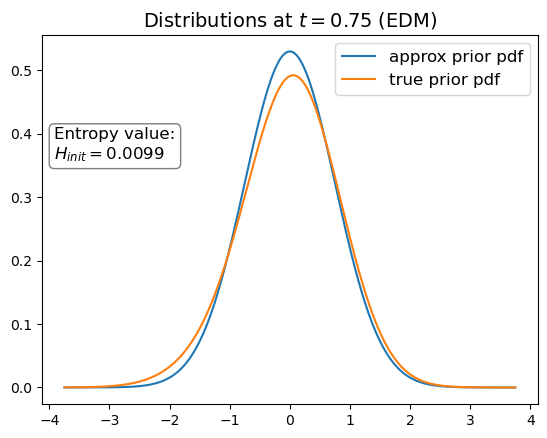

In [20]:
sigma = scheduler.scheduler_fns.noise_fn(initial_time_)
xlim = 5*sigma
exact_initial_entropy = analytical_initial_entropy(dataset, initial_time, scheduler=scheduler, plot=True, xlim=xlim, process=process,
                                                   fontsize=12)

In [21]:
# generate prior distributions
dataset.num_samples = nsamples
samples = dataset.sample()
sigma = scheduler.scheduler_fns.noise_fn(initial_time_)
scale = scheduler.scheduler_fns.scaling_fn(initial_time_)
initial_p = torch.randn_like(samples) * sigma * scale
exact_p = scheduler.apply_noise(samples, nsteps, initial_step)

In [22]:
exact_prior = False
prior = 'approx_prior'
if exact_prior:
    exact_initial_entropy = 0
    prior = 'exact_prior'

In [23]:
# data parameters
m = 1.1
p = 0.1
sigma_data = [0.2, 0.1]
factor_c = None

# compute bound
integral, error = compute_integral(0, initial_time-tmin, initial_time, m, p, sigma_data)
decay= np.exp(-integral)
bound_gauss = decay * exact_initial_entropy
print(f'Initial entropy: {exact_initial_entropy:.7f}')
print(f'Bound: {bound_gauss:.7f}')

Initial entropy: 0.0098865
Bound: 0.0070023


NoiseScheduler: EDMScheduler(
  (scheduler_fns): EDMSchedulingFunctions()
  (_integrator): HeunIntegrator()
  (stochastic_integrator): EulerMaruyamaIntegrator()
)
Exact initial entropy = 0.00989


C:\Users\bepsc\AppData\Local\Temp\ipykernel_55288\499128227.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma*scale)


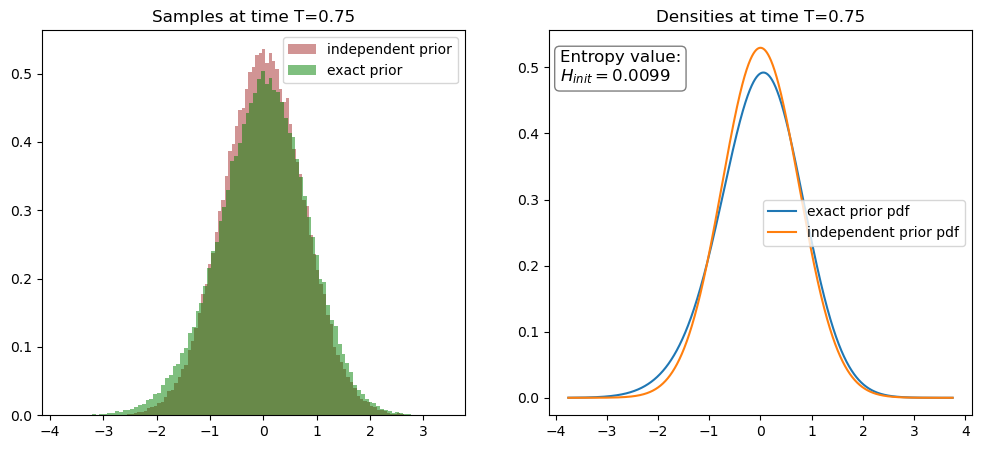

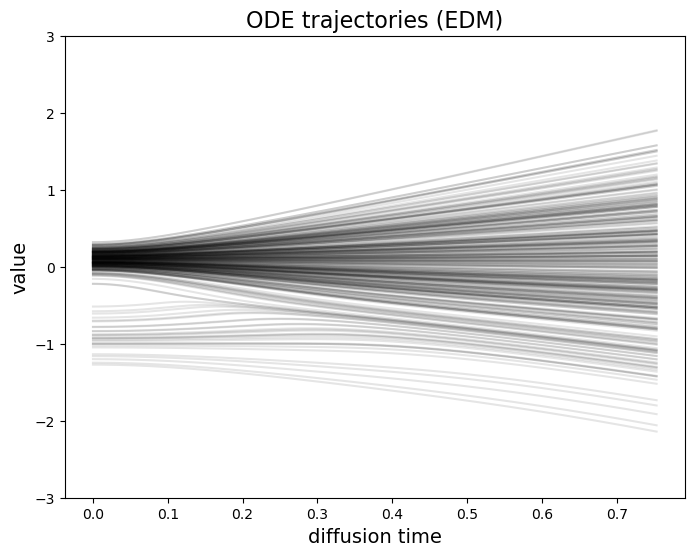

Saving samples to C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\outputdata\bps\entropy_paper\gaussian2\ode-indep_prior-an-nsamples=1e+05-nsteps=500-T=0.753-his-EDM


In [24]:
ode_history = generate_samples(initial_step, gamma, nsteps, nsamples, dataset, datatype, 
                               initial_p=initial_p, exact_p=exact_p, sample_type='ode',
                               noisescheduler=scheduler, scheduler_type = process, use_exact_prior=exact_prior)

NoiseScheduler: EDMScheduler(
  (scheduler_fns): EDMSchedulingFunctions()
  (_integrator): EulerIntegrator()
  (stochastic_integrator): EulerMaruyamaIntegrator()
)
Exact initial entropy = 0.00989


C:\Users\bepsc\AppData\Local\Temp\ipykernel_55288\499128227.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma*scale)


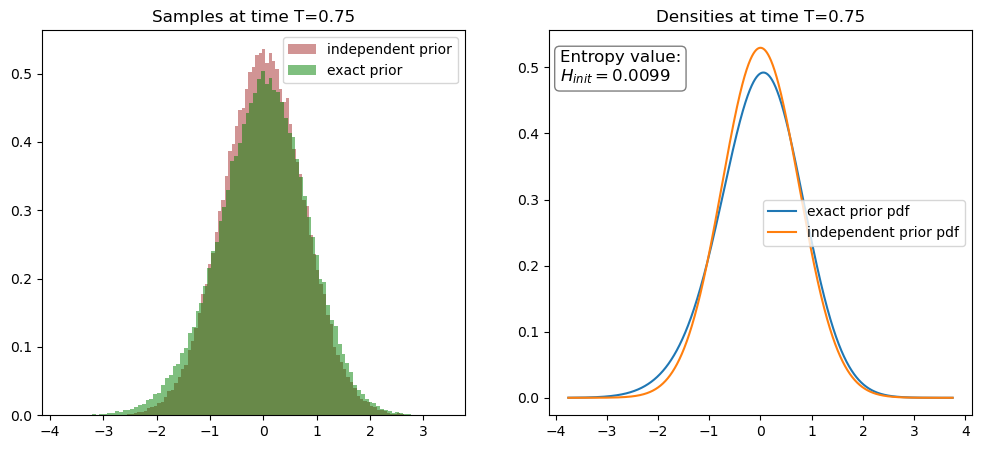

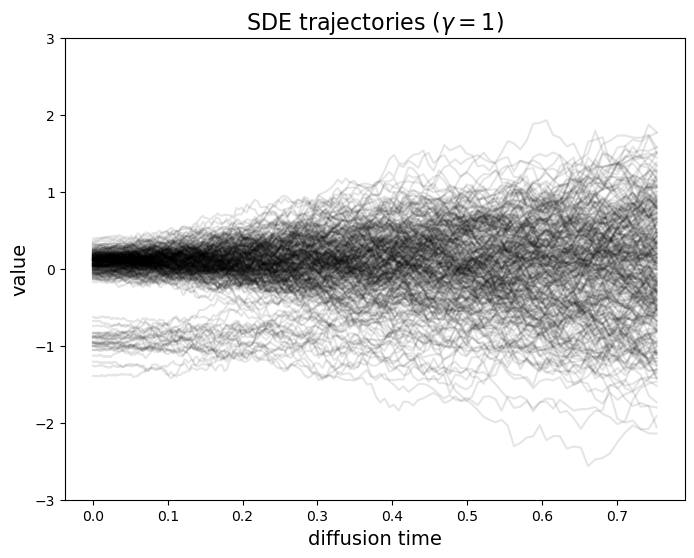

Saving samples to C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\outputdata\bps\entropy_paper\gaussian2\sde-indep_prior-an-nsamples=1e+05-nsteps=500-T=0.753-g=1-his-EDM


In [25]:
sde_history = generate_samples(initial_step, gamma, nsteps, nsamples, dataset, datatype,
                               initial_p=initial_p, exact_p=exact_p, sample_type='sde',
                               noisescheduler=scheduler, scheduler_type = process, use_exact_prior=exact_prior)

In [26]:
# # load data
# ode_path = r"C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\outputdata\bps\entropy_paper\gaussian2\ode-indep_prior-an-nsamples=1e+05-nsteps=500-T=0.211-his-VP"
# sde_path = r"C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\outputdata\bps\entropy_paper\gaussian2\sde-indep_prior-an-nsamples=1e+05-nsteps=500-T=0.211-g=1-his-VP"
# ode_history = torch.load(ode_path)
# sde_history = torch.load(sde_path)

In [27]:
ode_samples = ode_history[-1]
sde_samples = sde_history[-1]
ode_samples.shape, sde_samples.shape

(torch.Size([100000]), torch.Size([100000]))

In [28]:
nbins = 80

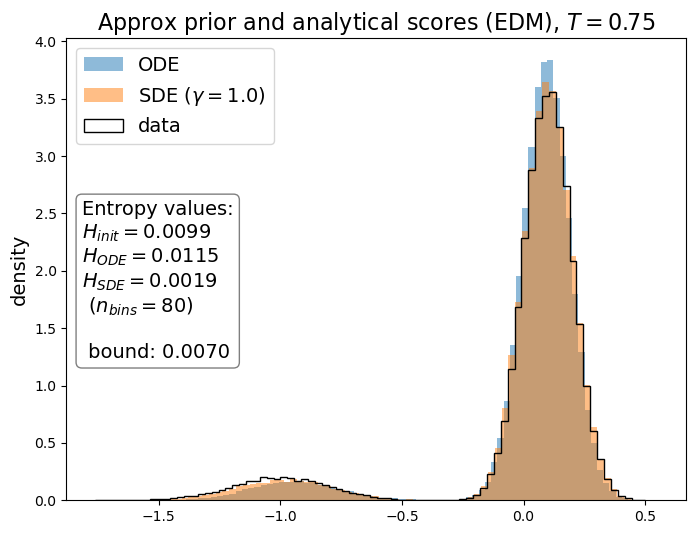

In [29]:
plot_figure(ode_samples, sde_samples, data, nsamples, nsteps, gamma, initial_time, datatype = datatype,
            nbins=nbins, initial_entropy=exact_initial_entropy, bound=bound_gauss,
            title=f'Approx prior and analytical scores ({process.upper()})', figname=f'{prior}-analytic-{process}',
            fontsize=14, savefig=True)

In [31]:
# Generate data for comparison
tmin = time[-2]
print(f'Final time: {tmin}')
sigma_min = scheduler.scheduler_fns.noise_fn(tmin)
scale_min = scheduler.scheduler_fns.scaling_fn(tmin)
noise = torch.randn_like(gaussian_samples2) * sigma_min * scale_min
diffused_gdata2 = scale_min * gaussian_samples2 + noise

diffused_data = diffused_gdata2

Final time: 0.0019999996293336153


In [32]:
# temporarily change gamma to 1
scheduler.langevin_const = 1

history_steps = nsteps+1-initial_step
forw_sde_history = scheduler.propagate_forward(diffused_data, dataset.gradlogprob, nsteps, record_history=True, stochastic=True)
forw_sde_history = forw_sde_history.cpu()
forw_sde_his = forw_sde_history[:history_steps].squeeze(-1)
forw_sde_his = forw_sde_his.flip(0)
forw_sde_his[-1] = data
forw_sde_his.shape

# unchange gamma
scheduler.langevin_const = gamma

In [33]:
forw_ode_history = scheduler.propagate_forward(diffused_data, dataset.gradlogprob, nsteps, record_history=True, stochastic=False)
forw_ode_history = forw_ode_history.cpu()
forw_ode_his = forw_ode_history[:history_steps-1].squeeze(-1)
forw_ode_his = forw_ode_his.flip(0)
forw_ode_his = torch.cat([forw_ode_his, data.unsqueeze(0)], dim=0)
forw_ode_his.shape

torch.Size([282, 100000])

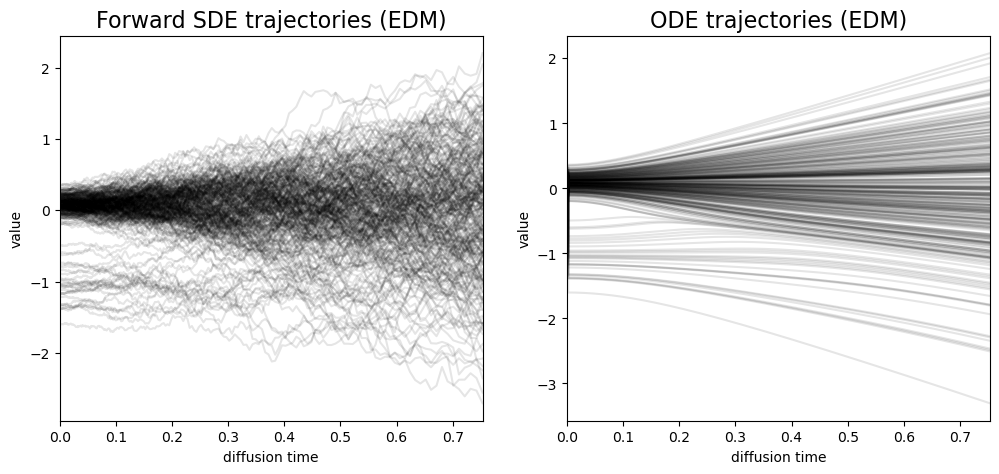

In [34]:
# plot forward trajectories
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
time2 = time[initial_step:]
nplot = 300
for i in range(nplot):
    x_sde = forw_sde_his[:, i].squeeze()
    x_ode = forw_ode_his[:, i].squeeze()
    axs[0].plot(time2, x_sde, color='black', linestyle='-', alpha=0.1)
    axs[1].plot(time2, x_ode, color='black', linestyle='-', alpha=0.1)
axs[0].set_title(f'Forward SDE trajectories ({process.upper()})', fontsize=16)
axs[1].set_title(f'ODE trajectories ({process.upper()})', fontsize=16)
for ax in axs:
    # ax.set_ylim([-3, 3])
    ax.set_xlim([0, initial_time])
    ax.set_xlabel("diffusion time")
    ax.set_ylabel("value")

In [35]:
# # save forward sde history
# gaussianpath = pathlib.Path('C:/Users/bepsc/OneDrive/Documentos/GitHub/DiffSci/outputdata/bps/entropy_paper/gaussian2')
# torch.save(forw_sde_his, gaussianpath / f'forw_sde_history-nsamples={nsamples:.0e}-nsteps={nsteps}-T={initial_time:.2f}-{process}')

# # load forward sde history
# forw_sde_his = torch.load(gaussianpath / f'forw_sde_history-nsamples={nsamples:.0e}-nsteps={nsteps}-T={initial_time:.2f}-{process}')

In [36]:
# generate bounds
time2 = time[initial_step:]
times = time2[0] - time2
bound_gauss_history = []
for t in times:
    integral, error = compute_integral(0, t, initial_time, m, p, sigma_data)
    decay = np.exp(-integral)
    bound_gauss = decay * exact_initial_entropy
    bound_gauss_history.append(bound_gauss)

C:\Users\bepsc\AppData\Local\Temp\ipykernel_55288\4151761813.py:48: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, error = integrate.quad(integrand, t_initial, t_final, args=(initial_time, m, p, sigma_data))


In [37]:
ode_history.shape, forw_sde_his.shape, len(bound_gauss_history)

(torch.Size([282, 100000]), torch.Size([282, 100000]), 282)

In [38]:
nbins = 50
ode_entropies, sde_entropies = compute_entropy_evolution(ode_history, sde_history, forw_sde_his, time2, mean=True, nbins=nbins)

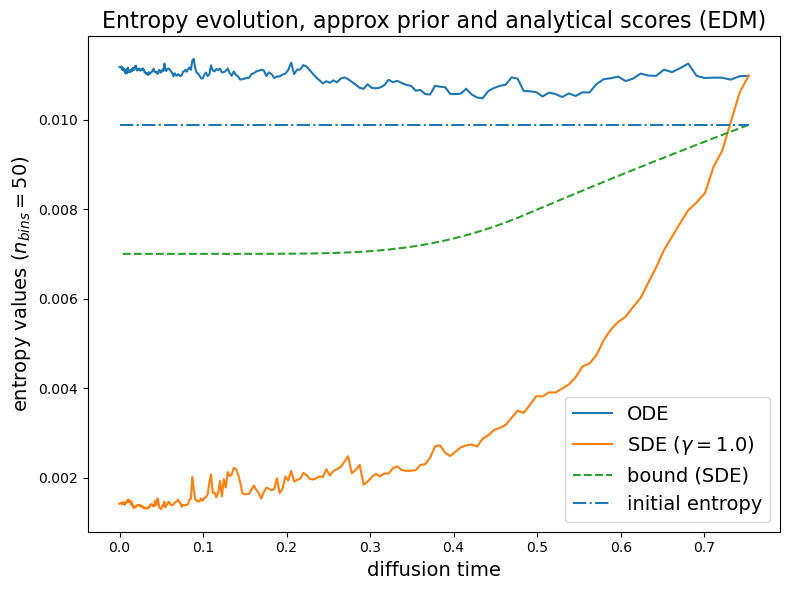

In [39]:
plot_entropy_evolution(ode_entropies, sde_entropies, time2, nsamples, gamma, initial_time, nsteps,
                       datatype, nbins=nbins, initial_entropy=exact_initial_entropy, bound_history=bound_gauss_history, exact_score=True,
                       title=f'Entropy evolution, approx prior and analytical scores ({process.upper()})', figname=f'entropy_evolution-{prior}-analytic-bound-{process}',
                       x_logscale=False, y_logscale=False)

Generate and plot multiple initial time

In [ ]:
# Define parameters
process = 'edm'

if process == 'edm':
    scheduler = diffsci.models.EDMScheduler(sigma_max=10.0)
    initial_time=0.75
elif process == 'vp':
    # scheduler = VPScheduler(sigma_max=20)
    scheduler = VPScheduler()
    initial_time=0.21
elif process == 've':
    scheduler = VEScheduler()
    initial_time=0.55
else:
    raise ValueError('Invalid process')

# initial_time = 2.0

initial_time_ = torch.tensor(initial_time)
nsteps = 500
gamma = 1
nsamples = 100000

initial_step = scheduler.step_from_time(t=initial_time_, n=nsteps)
time = scheduler.create_steps(nsteps+1)
initial_time = time[initial_step].item()
print(f'Initial step: {initial_step}')
print(f'Initial_time: {initial_time}')

Initial step: 219
Initial_time: 0.7530995011329651


In [46]:
time

tensor([1.0000e+01, 9.9017e+00, 9.8042e+00, 9.7075e+00, 9.6117e+00, 9.5167e+00,
        9.4224e+00, 9.3290e+00, 9.2364e+00, 9.1446e+00, 9.0535e+00, 8.9632e+00,
        8.8737e+00, 8.7850e+00, 8.6970e+00, 8.6098e+00, 8.5233e+00, 8.4376e+00,
        8.3526e+00, 8.2684e+00, 8.1849e+00, 8.1021e+00, 8.0200e+00, 7.9386e+00,
        7.8580e+00, 7.7780e+00, 7.6988e+00, 7.6202e+00, 7.5423e+00, 7.4652e+00,
        7.3886e+00, 7.3128e+00, 7.2376e+00, 7.1631e+00, 7.0893e+00, 7.0161e+00,
        6.9436e+00, 6.8717e+00, 6.8004e+00, 6.7298e+00, 6.6598e+00, 6.5904e+00,
        6.5217e+00, 6.4535e+00, 6.3860e+00, 6.3191e+00, 6.2528e+00, 6.1870e+00,
        6.1219e+00, 6.0574e+00, 5.9934e+00, 5.9300e+00, 5.8672e+00, 5.8050e+00,
        5.7434e+00, 5.6823e+00, 5.6217e+00, 5.5617e+00, 5.5023e+00, 5.4434e+00,
        5.3851e+00, 5.3272e+00, 5.2700e+00, 5.2132e+00, 5.1570e+00, 5.1013e+00,
        5.0461e+00, 4.9914e+00, 4.9372e+00, 4.8836e+00, 4.8304e+00, 4.7777e+00,
        4.7256e+00, 4.6739e+00, 4.6227e+

In [62]:
if process == 'edm':
    time_range = [time[-1], 2.5]
elif process == 'vp':
    time_range = [time[-1], 0.5]
elif process == 've':
    time_range = [time[-1], 5.0]
else:
    raise ValueError('Invalid process')

ntime = 20
time_values = custom_spacing(time_range[0], time_range[-1], ntime+1, alpha=0.5)
initial_steps = scheduler.step_from_time(time_values, nsteps)[1:]
time_values = time[initial_steps]
print(f'Initial steps: {initial_steps} \n Initial times: {time_values}')

Initial steps: tensor([462, 408, 371, 342, 318, 297, 278, 261, 246, 232, 219, 206, 195, 184,
        173, 163, 154, 145, 136, 127], dtype=torch.int32) 
 Initial times: tensor([0.0062, 0.0249, 0.0560, 0.0996, 0.1551, 0.2237, 0.3068, 0.4022, 0.5065,
        0.6239, 0.7531, 0.9046, 1.0525, 1.2207, 1.4113, 1.6063, 1.8011, 2.0157,
        2.2520, 2.5115])


In [64]:
ode_samples = generate_multiple_init_time(initial_steps, gamma, nsteps, nsamples, dataset, datatype,
                                          sample_type='ode', noisescheduler=scheduler, return_history=False,
                                          process=process)

In [65]:
sde_samples = generate_multiple_init_time(initial_steps, gamma, nsteps, nsamples, dataset, datatype,
                                            sample_type='sde', noisescheduler=scheduler, return_history=False,
                                            process=process)

In [66]:
initial_entropies = []
for t in time_values:
    s = scheduler.scheduler_fns.noise_fn(t)
    scale = scheduler.scheduler_fns.scaling_fn(t)
    xlim = 1 +5*s*scale
    exact_initial_entropy = analytical_initial_entropy(dataset, t, plot=False, xlim=xlim, scheduler=scheduler, process=process)
    initial_entropies.append(exact_initial_entropy)

C:\Users\bepsc\AppData\Local\Temp\ipykernel_55288\499128227.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = scheduler.scheduler_fns.noise_fn(torch.tensor(initial_time))
C:\Users\bepsc\AppData\Local\Temp\ipykernel_55288\499128227.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = scheduler.scheduler_fns.scaling_fn(torch.tensor(initial_time))
C:\Users\bepsc\AppData\Local\Temp\ipykernel_55288\499128227.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma*scale)


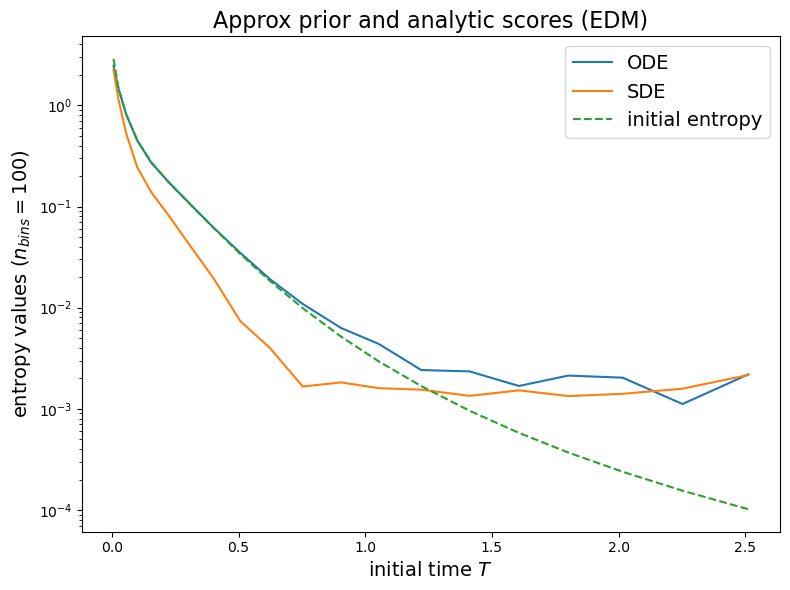

In [67]:
plot_multiple_init_time(sde_samples, diffused_data, time_values, gamma, datatype, nsteps, ntime=ntime,
                        ode_samples=ode_samples, nbins=100, initial_entropies=initial_entropies,
                        title=f'Approx prior and analytic scores ({process.upper()})', figname=f'approx_prior-analytic-{process}')

Generate multiple gamma

In [26]:
nsteps = 125
initial_step = scheduler.step_from_time(initial_time, nsteps)
time = scheduler.create_steps(nsteps+1)
print(f'Initial step: {initial_step}')
print(f'Initial_time: {time[initial_step].item()}')
samples125 = generate_multiple_gamma(initial_step, [0.01, 20], 125, nsamples, dataset, datatype,
                                    ngamma=40, noisescheduler=scheduler, return_history=False,
                                    alpha=0.5)

Initial step: 54
Initial_time: 0.7715094089508057
Initial time: 0.7715094089508057
Gamma values: tensor([1.0000e-02, 4.4989e-02, 1.0511e-01, 1.9037e-01, 3.0077e-01, 4.3630e-01,
        5.9697e-01, 7.8277e-01, 9.9371e-01, 1.2298e+00, 1.4910e+00, 1.7773e+00,
        2.0888e+00, 2.4254e+00, 2.7872e+00, 3.1741e+00, 3.5861e+00, 4.0232e+00,
        4.4855e+00, 4.9730e+00, 5.4855e+00, 6.0232e+00, 6.5861e+00, 7.1740e+00,
        7.7871e+00, 8.4254e+00, 9.0888e+00, 9.7773e+00, 1.0491e+01, 1.1230e+01,
        1.1994e+01, 1.2783e+01, 1.3597e+01, 1.4436e+01, 1.5301e+01, 1.6190e+01,
        1.7105e+01, 1.8045e+01, 1.9010e+01, 2.0000e+01])


In [27]:
nsteps = 250
initial_step = scheduler.step_from_time(initial_time, nsteps)
time = scheduler.create_steps(nsteps+1)
print(f'Initial step: {initial_step}')
print(f'Initial_time: {time[initial_step].item()}')
samples250 = generate_multiple_gamma(initial_step, [0.01, 40], 250, nsamples, dataset, datatype,
                                    ngamma=40, noisescheduler=scheduler, return_history=False,
                                    alpha=0.5)

Initial step: 109
Initial_time: 0.7591694593429565
Initial time: 0.7591694593429565
Gamma values: tensor([1.0000e-02, 6.7394e-02, 1.7574e-01, 3.3502e-01, 5.4526e-01, 8.0644e-01,
        1.1186e+00, 1.4816e+00, 1.8957e+00, 2.3606e+00, 2.8766e+00, 3.4434e+00,
        4.0612e+00, 4.7300e+00, 5.4497e+00, 6.2203e+00, 7.0419e+00, 7.9145e+00,
        8.8380e+00, 9.8124e+00, 1.0838e+01, 1.1914e+01, 1.3041e+01, 1.4220e+01,
        1.5449e+01, 1.6729e+01, 1.8060e+01, 1.9442e+01, 2.0875e+01, 2.2359e+01,
        2.3894e+01, 2.5480e+01, 2.7116e+01, 2.8804e+01, 3.0543e+01, 3.2332e+01,
        3.4173e+01, 3.6064e+01, 3.8007e+01, 4.0000e+01])


In [28]:
nsteps = 500
initial_step = scheduler.step_from_time(initial_time, nsteps)
time = scheduler.create_steps(nsteps+1)
print(f'Initial step: {initial_step}')
print(f'Initial_time: {time[initial_step].item()}')
samples500 = generate_multiple_gamma(initial_step, [0.01, 80], nsteps, nsamples, dataset, datatype,
                                  ngamma=40, noisescheduler=scheduler, return_history=False,
                                  alpha=0.5)

Initial step: 219
Initial_time: 0.7530995011329651
Initial time: 0.7530995011329651
Gamma values: tensor([1.0000e-02, 1.0678e-01, 3.0642e-01, 6.0891e-01, 1.0143e+00, 1.5225e+00,
        2.1335e+00, 2.8474e+00, 3.6642e+00, 4.5838e+00, 5.6063e+00, 6.7316e+00,
        7.9598e+00, 9.2909e+00, 1.0725e+01, 1.2262e+01, 1.3901e+01, 1.5644e+01,
        1.7489e+01, 1.9437e+01, 2.1488e+01, 2.3642e+01, 2.5899e+01, 2.8258e+01,
        3.0721e+01, 3.3286e+01, 3.5954e+01, 3.8725e+01, 4.1599e+01, 4.4576e+01,
        4.7655e+01, 5.0838e+01, 5.4123e+01, 5.7511e+01, 6.1002e+01, 6.4596e+01,
        6.8293e+01, 7.2092e+01, 7.5995e+01, 8.0000e+01])


In [29]:
nsteps = 1000
initial_step = scheduler.step_from_time(initial_time, nsteps)
time = scheduler.create_steps(nsteps+1)
print(f'Initial step: {initial_step}')
print(f'Initial_time: {time[initial_step].item()}')
samples1000 = generate_multiple_gamma(initial_step, [0.01, 160], nsteps, nsamples, dataset, datatype,
                                    ngamma=40, noisescheduler=scheduler, return_history=False,
                                    alpha=0.5)

Initial step: 438
Initial_time: 0.7554612159729004
Initial time: 0.7554612159729004
Gamma values: tensor([1.0000e-02, 1.7789e-01, 5.5286e-01, 1.1349e+00, 1.9240e+00, 2.9202e+00,
        4.1235e+00, 5.5338e+00, 7.1512e+00, 8.9757e+00, 1.1007e+01, 1.3246e+01,
        1.5692e+01, 1.8344e+01, 2.1204e+01, 2.4271e+01, 2.7545e+01, 3.1026e+01,
        3.4714e+01, 3.8610e+01, 4.2712e+01, 4.7021e+01, 5.1538e+01, 5.6261e+01,
        6.1192e+01, 6.6330e+01, 7.1674e+01, 7.7226e+01, 8.2985e+01, 8.8951e+01,
        9.5124e+01, 1.0150e+02, 1.0809e+02, 1.1489e+02, 1.2189e+02, 1.2910e+02,
        1.3651e+02, 1.4413e+02, 1.5196e+02, 1.6000e+02])


In [30]:
nsteps = 2000
initial_step = scheduler.step_from_time(initial_time, nsteps)
time = scheduler.create_steps(nsteps+1)
print(f'Initial step: {initial_step}')
print(f'Initial_time: {time[initial_step].item()}')
samples2000 = generate_multiple_gamma(initial_step, [0.01, 320], nsteps, nsamples, dataset, datatype,
                                    ngamma=40, noisescheduler=scheduler, return_history=False,
                                    alpha=0.5)

Initial step: 877
Initial_time: 0.7539503574371338
Initial time: 0.7539503574371338
Gamma values: tensor([1.0000e-02, 3.0927e-01, 1.0246e+00, 2.1561e+00, 3.7036e+00, 5.6672e+00,
        8.0469e+00, 1.0843e+01, 1.4054e+01, 1.7682e+01, 2.1726e+01, 2.6187e+01,
        3.1063e+01, 3.6355e+01, 4.2063e+01, 4.8188e+01, 5.4728e+01, 6.1685e+01,
        6.9058e+01, 7.6846e+01, 8.5051e+01, 9.3672e+01, 1.0271e+02, 1.1216e+02,
        1.2203e+02, 1.3232e+02, 1.4302e+02, 1.5414e+02, 1.6567e+02, 1.7762e+02,
        1.8998e+02, 2.0277e+02, 2.1596e+02, 2.2958e+02, 2.4361e+02, 2.5805e+02,
        2.7292e+02, 2.8820e+02, 3.0389e+02, 3.2000e+02])


Gamma values: tensor([1.0000e-02, 6.7394e-02, 1.7574e-01, 3.3502e-01, 5.4526e-01, 8.0644e-01,
        1.1186e+00, 1.4816e+00, 1.8957e+00, 2.3606e+00, 2.8766e+00, 3.4434e+00,
        4.0612e+00, 4.7300e+00, 5.4497e+00, 6.2203e+00, 7.0419e+00, 7.9145e+00,
        8.8380e+00, 9.8124e+00, 1.0838e+01, 1.1914e+01, 1.3041e+01, 1.4220e+01,
        1.5449e+01, 1.6729e+01, 1.8060e+01, 1.9442e+01, 2.0875e+01, 2.2359e+01,
        2.3894e+01, 2.5480e+01, 2.7116e+01, 2.8804e+01, 3.0543e+01, 3.2332e+01,
        3.4173e+01, 3.6064e+01, 3.8007e+01, 4.0000e+01])
Gamma values: tensor([1.0000e-02, 1.0678e-01, 3.0642e-01, 6.0891e-01, 1.0143e+00, 1.5225e+00,
        2.1335e+00, 2.8474e+00, 3.6642e+00, 4.5838e+00, 5.6063e+00, 6.7316e+00,
        7.9598e+00, 9.2909e+00, 1.0725e+01, 1.2262e+01, 1.3901e+01, 1.5644e+01,
        1.7489e+01, 1.9437e+01, 2.1488e+01, 2.3642e+01, 2.5899e+01, 2.8258e+01,
        3.0721e+01, 3.3286e+01, 3.5954e+01, 3.8725e+01, 4.1599e+01, 4.4576e+01,
        4.7655e+01, 5.0838e+01, 5.4

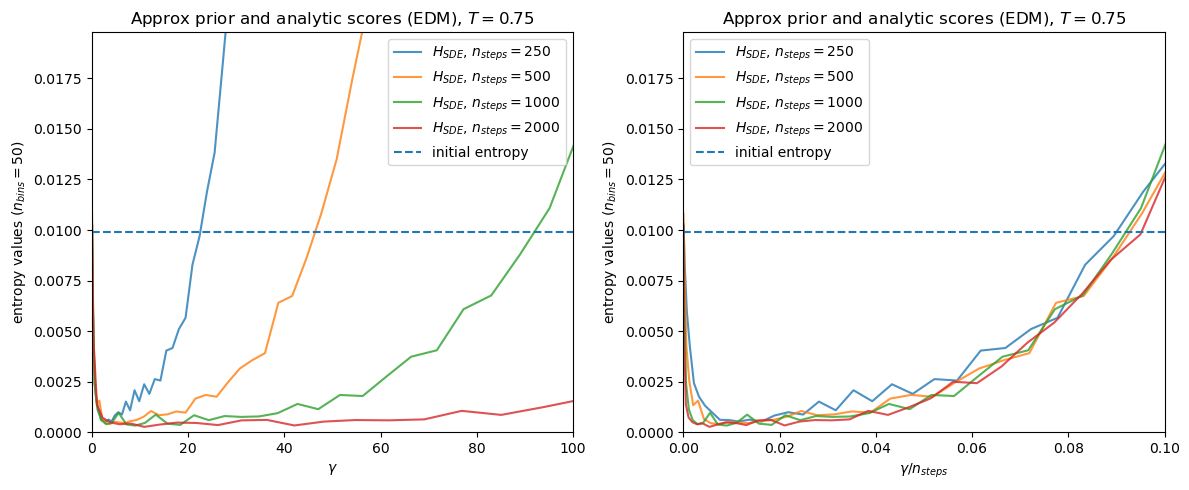

In [31]:
data = [(samples250, [0.01, 40], 40, 250), (samples500, [0.01, 80], 40, 500),
        (samples1000, [0.01, 160], 40, 1000), (samples2000, [0.01, 320], 40, 2000)]

plot_multiple_gamma2(data, data_, initial_time, datatype, initial_entropy=exact_initial_entropy,
                     nbins=50, figname='approx_prior-analytic-alpha=0.5-2',
                     title=f'Approx prior and analytic scores ({process.upper()})', alpha=0.5, xlim=100)  

Learned score functions

In [24]:
import lightning
import lightning.pytorch.callbacks as callbacks
import lightning.pytorch.loggers as pl_loggers

from diffsci.models import KarrasModule, KarrasModuleConfig

In [25]:
dataset = gaussian_dataset2

In [26]:
# data for training
batch_size = 16
train_size = int(nsamples*0.5)
test_size = int(nsamples*0.5)
num_workers=0
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# model

noise_log_mean = -2
config = KarrasModuleConfig.from_edm(prior_mean = noise_log_mean)
layers = [100, 100, 100]
model = diffsci.models.MLPUncond(1, layers, nonlinearity=torch.nn.SiLU(), dropout=0.1)
module = KarrasModule(model, config)

# training parameters
learning_rate = 4e-4
module.optimizer = torch.optim.AdamW(module.parameters(),
                                    lr=learning_rate,)
module.lr_scheduler = None
num_epochs = 15

In [27]:
# set trainer

savefolderstr = f"mixt_gauss2_silu-{layers}-lr={learning_rate}-bs={batch_size}-nsamples={nsamples}"
MODELSPATH = 'C:/Users/bepsc/OneDrive/Documentos/GitHub/DiffSci/savedmodels/experimental'
savedir = os.path.join(MODELSPATH, savefolderstr)

checkpoint_callback = callbacks.ModelCheckpoint(
        monitor='valid_loss',
        dirpath=os.path.join(savedir, 'checkpoints'),
        filename='sample-{epoch:02d}-{valid_loss:.6f}',
        save_top_k=3,
        mode='min',
    )

tb_logger = pl_loggers.TensorBoardLogger(save_dir=savedir, name='logs')

trainer = lightning.Trainer(max_epochs=num_epochs,
                            logger=tb_logger,
                            callbacks=[checkpoint_callback],
                            fast_dev_run=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
# # train model

# trainer.fit(model=module,
#             train_dataloaders=train_dataloader,
#             val_dataloaders=test_dataloader)

In [29]:
# load model (substitute by your checkpointpath)

checkpointpath = r"C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\savedmodels\experimental\mixt_gauss2_silu-[100, 100, 100]-lr=0.0004-bs=16-nsamples=100000\checkpoints\sample-epoch=09-valid_loss=0.292705.ckpt"
module = KarrasModule.load_from_checkpoint(model=model, config=config, checkpoint_path=checkpointpath)
datatype = 'gaussian2'

In [30]:
# Define parameters
process = 'edm'

if process == 'edm':
    scheduler = diffsci.models.EDMScheduler(sigma_max=10.0)
    initial_time=0.75
elif process == 'vp':
    scheduler = VPScheduler()
    initial_time=0.205
elif process == 've':
    scheduler = VEScheduler()
    initial_time=0.55
else:
    raise ValueError('Invalid process')

initial_time_ = torch.tensor(initial_time)
nsteps = 500
gamma = 1
nsamples = 100000

initial_step = scheduler.step_from_time(t=initial_time_, n=nsteps)
time = scheduler.create_steps(nsteps+1)
initial_time = time[initial_step].item()
print(f'Initial step: {initial_step}')
print(f'Initial_time: {initial_time}')

Initial step: 219
Initial_time: 0.7530995011329651


In [31]:
# choose dataset
data_ = gaussian_samples2
data = data_.squeeze(-1)
dataset = gaussian_dataset2
datatype = 'gaussian2'

In [32]:
interval = None
# interval = [0.1, 1.0]

C:\Users\bepsc\AppData\Local\Temp\ipykernel_49960\499128227.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma*scale)


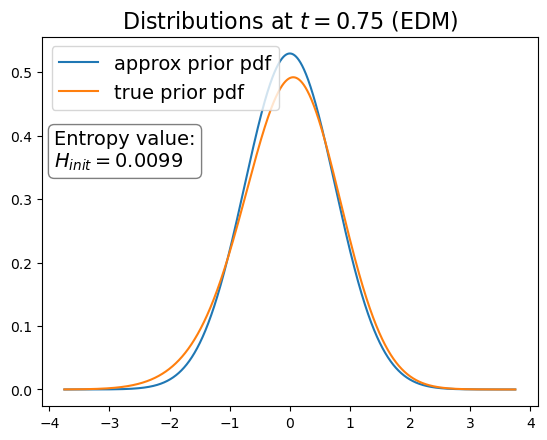

In [33]:
sigma = scheduler.scheduler_fns.noise_fn(initial_time_)
xlim = 5*sigma
exact_initial_entropy = analytical_initial_entropy(dataset, initial_time, scheduler=scheduler, plot=True, xlim=xlim, process=process)

In [34]:
# Generate data for comparison
tmin = time[-2]
print(f'Final time: {tmin}')
sigma_min = scheduler.scheduler_fns.noise_fn(tmin)
scale_min = scheduler.scheduler_fns.scaling_fn(tmin)
noise = torch.randn_like(gaussian_samples2) * sigma_min * scale_min

diffused_gdata2 = scale_min * gaussian_samples2 + noise
diffused_data = diffused_gdata2

Final time: 0.0019999996293336153


In [35]:
# temporarily change gamma to 1
scheduler.langevin_const = 1

history_steps = nsteps+1-initial_step
forw_sde_history = scheduler.propagate_forward(diffused_data, dataset.gradlogprob, nsteps, record_history=True, stochastic=True)
forw_sde_history = forw_sde_history.cpu()
forw_sde_his = forw_sde_history[:history_steps].squeeze(-1)
forw_sde_his = forw_sde_his.flip(0)
forw_sde_his[-1] = data
forw_sde_his.shape

# unchange gamma
scheduler.langevin_const = gamma

In [36]:
# generate prior distributions
dataset.num_samples = nsamples
samples = dataset.sample()
sigma = scheduler.scheduler_fns.noise_fn(initial_time_)
scale = scheduler.scheduler_fns.scaling_fn(initial_time_)
initial_p = torch.randn_like(samples) * sigma * scale
exact_p = scheduler.apply_noise(samples, nsteps, initial_step)

In [37]:
exact_prior = False

prior = 'approx_prior'
if exact_prior:
    exact_initial_entropy = 0
    prior = 'exact_prior'

NoiseScheduler: EDMScheduler(
  (scheduler_fns): EDMSchedulingFunctions()
  (_integrator): HeunIntegrator()
  (stochastic_integrator): EulerMaruyamaIntegrator()
)
Exact initial entropy = 0.00989


C:\Users\bepsc\AppData\Local\Temp\ipykernel_20328\499128227.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma*scale)


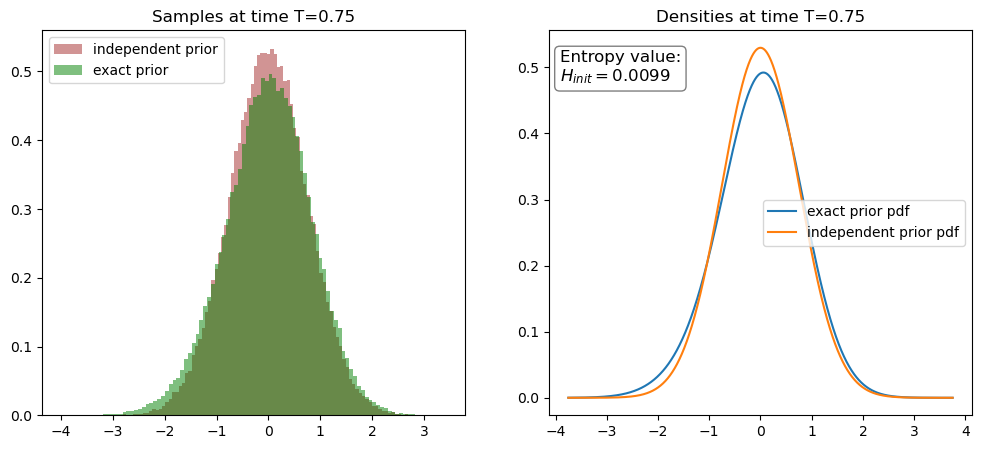

Sampling with learned scores, device:  cuda:0


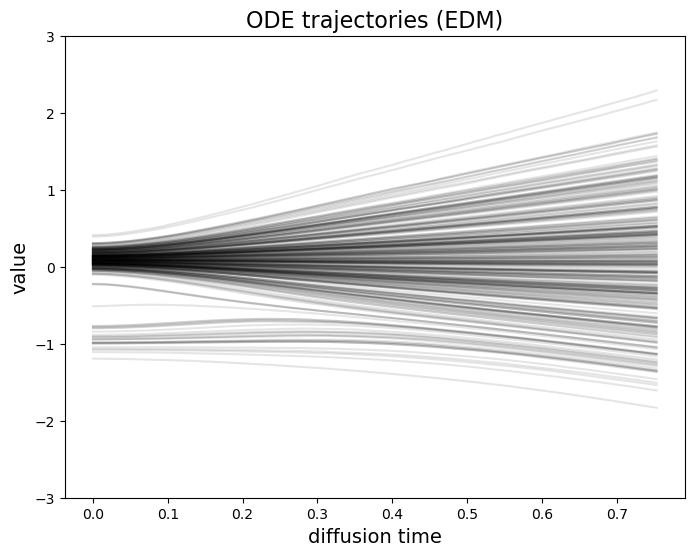

Saving samples to C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\savedmodels\experimental\mixt_gauss2_silu-[100, 100, 100]-lr=0.0004-bs=16-nsamples=100000\saved_samples\ode-indep_prior-tr-nsamples=1e+05-nsteps=500-T=0.753-his-EDM


In [48]:
ode_history = generate_samples(initial_step, gamma, nsteps, nsamples, dataset, module=module, 
                               exact_p=exact_p, initial_p=initial_p, sample_type='ode',
                               checkpoint=checkpointpath, datatype=datatype, interval=interval, use_exact_prior=exact_prior,
                               return_history=True, noisescheduler=scheduler, scheduler_type=process)

NoiseScheduler: EDMScheduler(
  (scheduler_fns): EDMSchedulingFunctions()
  (_integrator): EulerIntegrator()
  (stochastic_integrator): EulerMaruyamaIntegrator()
  (_temporary_integrator): None
)
Exact initial entropy = 0.00989


C:\Users\bepsc\AppData\Local\Temp\ipykernel_20328\499128227.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma*scale)


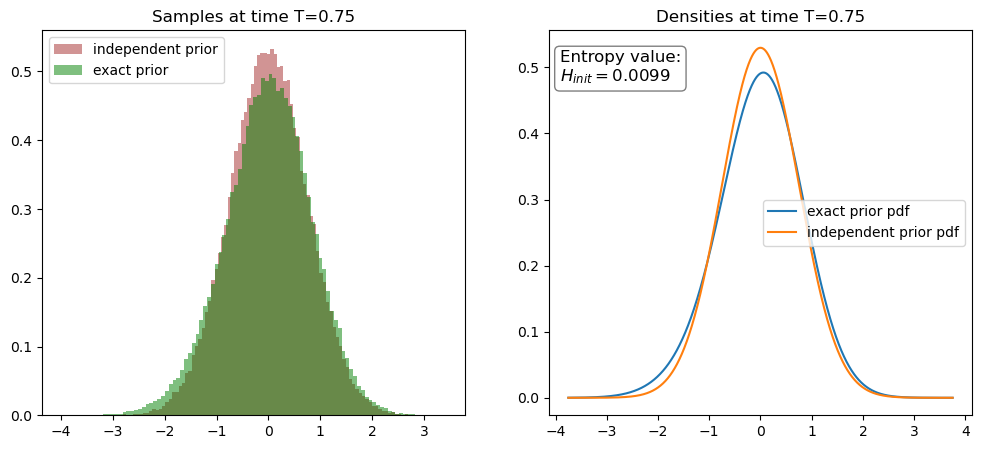

Sampling with learned scores, device:  cuda:0


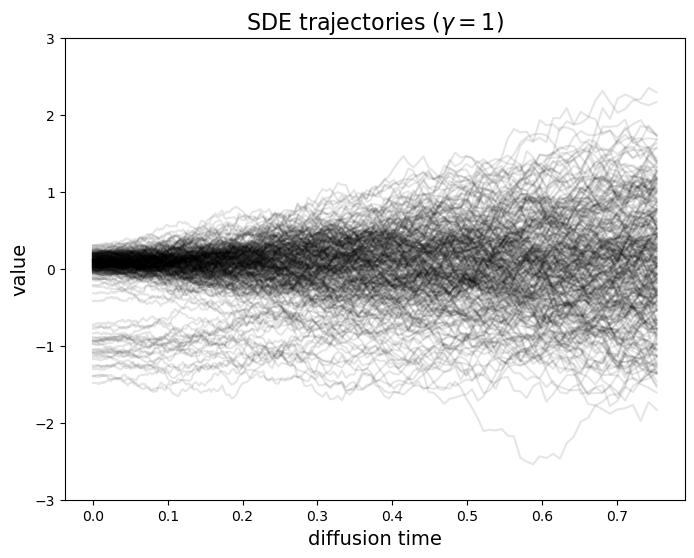

Saving samples to C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\savedmodels\experimental\mixt_gauss2_silu-[100, 100, 100]-lr=0.0004-bs=16-nsamples=100000\saved_samples\sde-indep_prior-tr-nsamples=1e+05-nsteps=500-T=0.753-g=1-his-EDM


In [49]:
sde_history = generate_samples(initial_step, gamma, nsteps, nsamples, dataset, module=module,
                               exact_p=exact_p, initial_p=initial_p, sample_type='sde',
                               checkpoint=checkpointpath, datatype=datatype, interval=interval, use_exact_prior=exact_prior,
                               return_history=True, noisescheduler=scheduler, scheduler_type=process)

In [50]:
# # load data

# ode_path = r"C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\savedmodels\experimental\mixt_gauss2_silu-[100, 100, 100]-lr=0.0004-bs=16-nsamples=100000\saved_samples\ode-indep_prior-tr-nsamples=1e+05-nsteps=500-T=0.205-his-VP"
# sde_path = r"C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\savedmodels\experimental\mixt_gauss2_silu-[100, 100, 100]-lr=0.0004-bs=16-nsamples=100000\saved_samples\sde-indep_prior-tr-nsamples=1e+05-nsteps=500-T=0.205-g=1-his-VP"
# sde_history = torch.load(sde_path)
# ode_history = torch.load(ode_path)

In [51]:
ode_samples = ode_history[-1]
sde_samples = sde_history[-1]

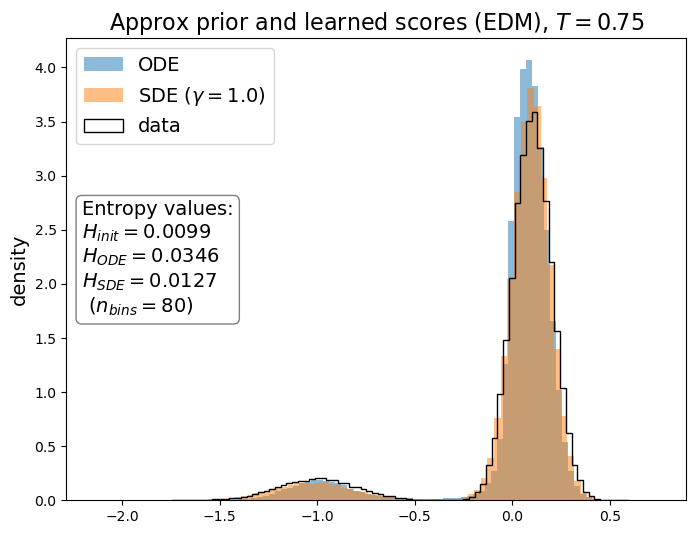

In [52]:
nbins = 80
plot_figure(ode_samples, sde_samples, data, nsamples, nsteps, gamma, initial_time, datatype = datatype,
            nbins=nbins,
            initial_entropy=exact_initial_entropy,
            title=f'Approx prior and learned scores ({process.upper()})', figname=f'{prior}-learned-silu5-{process}-nobound')

In [53]:
time2 = time[initial_step:]
nbins = 50
ode_entropies, sde_entropies = compute_entropy_evolution(ode_history, sde_history, forw_sde_his, time2, nbins=nbins)

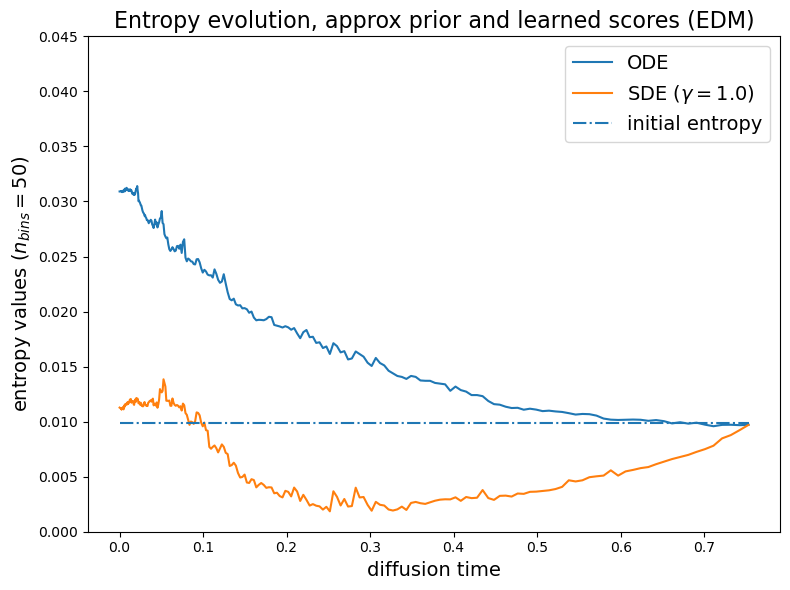

In [54]:
plot_entropy_evolution(ode_entropies, sde_entropies, time2, nsamples, gamma, initial_time, nsteps, datatype,
                       nbins=nbins,
                       initial_entropy=exact_initial_entropy,
                       title=f'Entropy evolution, approx prior and learned scores ({process.upper()})',
                       figname=f'entropy_evolution-{prior}-learned-silu5-{process}-nobound',
                       x_logscale=False, y_logscale=False, ylim=0.045)

In [ ]:
# def integrand1(rev_t, d):
#     t = initial_time - rev_t       # since for EDM sigma(rev_t) = t
#     if datatype == 'gaussian':
#         Const = c_gauss(t, m, p, sigma_data)
#     elif datatype == 'gaussian2':
#         Const = c_gauss2(t, m, p, sigma_data)
#     if Const == float('inf'):
#         inv_C = 0
#     else:
#         inv_C = 1/Const
#     delta = d * gamma
#     return inv_C * g_squared(t, process) * (gamma - delta)

# def compute_integral1(t_initial, t_final, d):
#     result, error = integrate.quad(integrand1, t_initial, t_final, args=(d,))
#     return result

In [ ]:
# compute theorectical bound for the SDE with approximated scores

def g_squared(t, process):
    if process == 'edm':
        g2 = 2*t
    elif process == 'vp':
        beta_min = 0.1
        beta_d = 19.9
        g2 = beta_d * t + beta_min
    elif process == 've':
        g2 = 1
    return g2


def compute_integral1_discrete(step_initial, step_final, d_values):
    result = 0
    for step in range(step_initial, step_final):
        t = time[step]
        delta = d_values[step - initial_step] * gamma
        if datatype == 'gaussian':
            const = c_gauss(t, m, p, sigma_data)
        elif datatype == 'gaussian2':
            const = c_gauss2(t, m, p, sigma_data)
        if const == float('inf'):
            inv_C = 0
        else:
            inv_C = 1/const
        result += inv_C * g_squared(t, process) * (gamma - delta) * (time[step] - time[step+1])
    return result

def epsilon_norm(step, sde_history, interp_fn, datasize = 2000):
    x = sde_history[step-initial_step, :datasize,].cpu()
    x = x.unsqueeze(-1)
    t = time[step]
    sigma = scheduler.scheduler_fns.noise_fn(t * torch.ones(x.shape[0]))
    x_ = x.to(module.device)
    sigma_ = sigma.to(x_)
    s = scheduler.scheduler_fns.scaling_fn(t)
    score = module.get_score(x_/s, sigma_)
    analytic_score = dataset.gradlogprob(x, sigma).to(score)
    if interp_fn is not None:
        score_dist = torch.mean((interp_fn(t)*(score - analytic_score))**2)
    else:
        score_dist = torch.mean((score - analytic_score)**2)
    return score_dist.detach().cpu().numpy()


def compute_integral2_discrete(initial_step, step_final, tmin, d, sde_history, interp_fn):
    result = 0
    epsilon_ = []
    for step in range(initial_step, step_final):
        t = time[step]
        rev_t = initial_time - t
        if isinstance(d, list):
            integral1 = compute_integral1_discrete(step, step_final, d)
            delta = d[step - initial_step] * gamma
        else:
            raise ValueError('d must be a list of values for each step')
        weight = 1/8 * 1/delta * g_squared(t, process) * (1 + gamma)**2 * np.exp(-integral1)
        epsilon = epsilon_norm(step, sde_history, interp_fn)
        epsilon_.append(epsilon)
        result += weight * epsilon * (time[step] - time[step+1])
    return result, epsilon_

def compute_bound(initial_entropy, d, tmin, history, step_final=nsteps, interp_fn=None):
    if isinstance(d, list):
        integral1 = compute_integral1_discrete(initial_step, step_final, d)
    else:
        raise ValueError('d must be a list of values for each step')
    integral2, score_error = compute_integral2_discrete(initial_step, step_final, tmin, d, history, interp_fn)
    bound = np.exp(-integral1) * initial_entropy + integral2
    return bound, score_error

In [56]:
def compute_inv_bound(initial_entropy, history, step_final=nsteps):
    result = initial_entropy
    score_error = []
    for step in range(initial_step, step_final):
        t = time[step]
        epsilon = epsilon_norm(step, history, None)
        score_error.append(epsilon)
        result += 1/8 * g_squared(t, process) * (1 + gamma)**2 /gamma * epsilon * (time[step] - time[step+1])
    return result, score_error

In [58]:
# compute bound
m = 1.1
p = 0.1
sigma_data = [0.2, 0.1]

factor_c = None
bound_values = []
d_values = np.linspace(0, 1, 10)
for d in d_values:
    d_val = [d]*len(sde_history)
    bound, score_error = compute_bound(exact_initial_entropy, d_val, tmin, sde_history)
    bound_values.append(bound)

C:\Users\bepsc\AppData\Local\Temp\ipykernel_20328\4151761813.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = scheduler.scheduler_fns.noise_fn(torch.tensor(t))
C:\Users\bepsc\AppData\Local\Temp\ipykernel_20328\4151761813.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = scheduler.scheduler_fns.scaling_fn(torch.tensor(t))
C:\Users\bepsc\AppData\Local\Temp\ipykernel_20328\3875521312.py:60: RuntimeWarning: divide by zero encountered in scalar divide
  weight = 1/8 * 1/delta * g_squared(t, process) * (1 + gamma)**2 * np.exp(-integral1)


In [59]:
# # save score error

# path = os.path.dirname(checkpointpath)
# path = os.path.dirname(path)
# path = os.path.join(path, 'saved_samples')
# torch.save(score_error, os.path.join(path, f'score_error-{prior}-{process}-g={gamma}'))

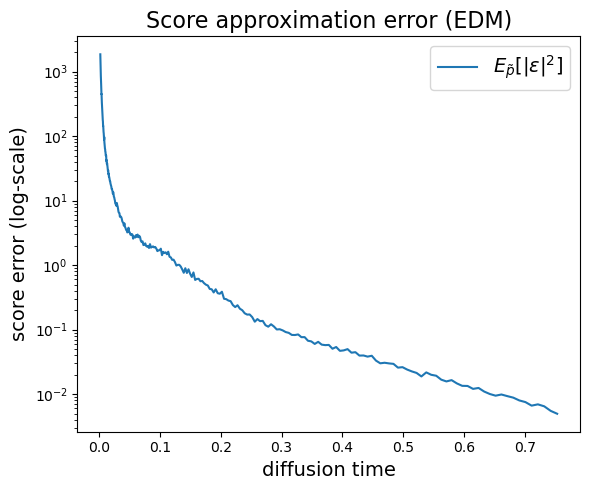

In [60]:
# plot score error
fontsize = 14
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
time_plot = time[initial_step:-1].squeeze(-1)
ax.plot(time_plot, score_error, label='$E_{\~p}[|\epsilon|^2]$')
ax.set_yscale('log')
ax.set_title(f'Score approximation error ({process.upper()})', fontsize=fontsize+2)
ax.set_xlabel('diffusion time', fontsize=fontsize)
ax.set_ylabel('score error (log-scale)', fontsize=fontsize)
# ax.set_ylabel('score error')
ax.legend(fontsize=fontsize)
plt.tight_layout()

In [61]:
# compute entropies
ode_entropy, sde_entropy = approx_entropy(ode_samples, sde_samples, diffused_data, nbins=nbins)

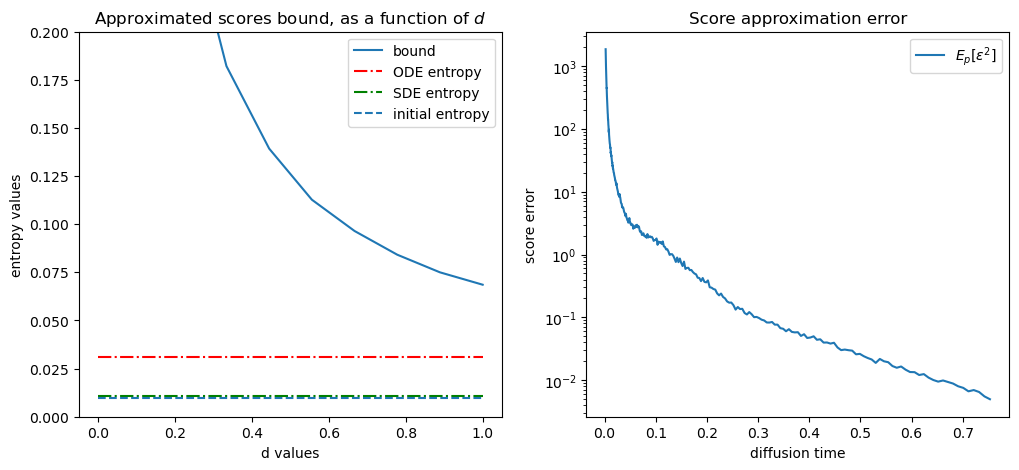

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plot the bound for approximated scores as a function of d
axs[0].plot(d_values, bound_values, label='bound')
axs[0].hlines(ode_entropy, d_values[0], d_values[-1], label='ODE entropy', linestyle='-.', color='red')
axs[0].hlines(sde_entropy, d_values[0], d_values[-1], label='SDE entropy', linestyle='-.', color='green')
axs[0].hlines(exact_initial_entropy, d_values[0], d_values[-1], label='initial entropy', linestyle='--')
axs[0].set_ylim(0, 0.2)
axs[0].set_xlabel('d values')
axs[0].set_ylabel('entropy values')
axs[0].legend()
axs[0].set_title('Approximated scores bound, as a function of $d$')

# plot score error
time_plot = time[initial_step:-1].squeeze(-1)
axs[1].plot(time_plot, score_error, label='$E_{p}[\epsilon^2]$')
axs[1].set_yscale('log')
axs[1].set_title('Score approximation error')
axs[1].set_xlabel('diffusion time')
axs[1].set_ylabel('score error')
axs[1].legend()

In [65]:
# compute bound history for d=1

d_val = [1]*len(time2)
bound1d_history = []
for step_final in range(initial_step, nsteps):
    print(f'step={step_final}')
    bound1d, _ = compute_bound(exact_initial_entropy, d_val, tmin, sde_history, step_final=step_final)
    bound1d_history.append(bound1d)
bound1d_history2 = bound1d_history.copy()
bound1d_history2.append(bound1d_history[-1])

step=219
step=220
step=221
step=222
step=223
step=224
step=225
step=226
step=227
step=228
step=229


C:\Users\bepsc\AppData\Local\Temp\ipykernel_20328\4151761813.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = scheduler.scheduler_fns.noise_fn(torch.tensor(t))
C:\Users\bepsc\AppData\Local\Temp\ipykernel_20328\4151761813.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = scheduler.scheduler_fns.scaling_fn(torch.tensor(t))


step=230
step=231
step=232
step=233
step=234
step=235
step=236
step=237
step=238
step=239
step=240
step=241
step=242
step=243
step=244
step=245
step=246
step=247
step=248
step=249
step=250
step=251
step=252
step=253
step=254
step=255
step=256
step=257
step=258
step=259
step=260
step=261
step=262
step=263
step=264
step=265
step=266
step=267
step=268
step=269
step=270
step=271
step=272
step=273
step=274
step=275
step=276
step=277
step=278
step=279
step=280
step=281
step=282
step=283
step=284
step=285
step=286
step=287
step=288
step=289
step=290
step=291
step=292
step=293
step=294
step=295
step=296
step=297
step=298
step=299
step=300
step=301
step=302
step=303
step=304
step=305
step=306
step=307
step=308
step=309
step=310
step=311
step=312
step=313
step=314
step=315
step=316
step=317
step=318
step=319
step=320
step=321
step=322
step=323
step=324
step=325
step=326
step=327
step=328
step=329
step=330
step=331
step=332
step=333
step=334
step=335
step=336
step=337
step=338
step=339
step=340
s

In [66]:
# # save bound

# path = os.path.dirname(checkpointpath)
# path = os.path.dirname(path)
# path = os.path.join(path, 'saved_samples')
# torch.save(bound1d_history2, os.path.join(path, f'bound1d_history-{prior}-{process}-g={gamma}'))

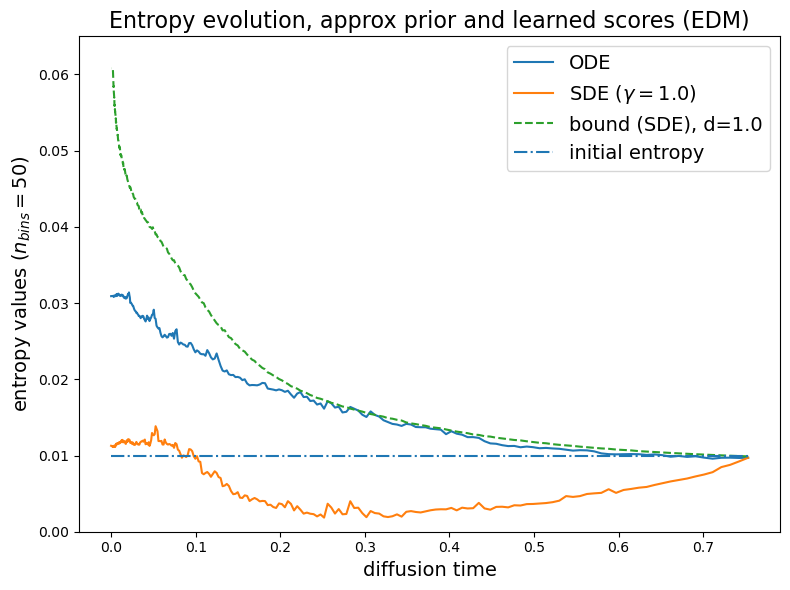

In [69]:
plot_entropy_evolution(ode_entropies, sde_entropies, time2, nsamples, gamma, initial_time, nsteps, datatype,
                       nbins=nbins,
                       bound_history=[[bound1d_history2, 1.0]],
                       initial_entropy=exact_initial_entropy,
                       title=f'Entropy evolution, approx prior and learned scores ({process.upper()})',
                       figname=f'entropy_evolution-{prior}-learned-silu5-{process}-delta1d',
                       x_logscale=False, y_logscale=False, ylim=0.065)

In [70]:
bound1d = bound1d_history2[-1]
nbins=80

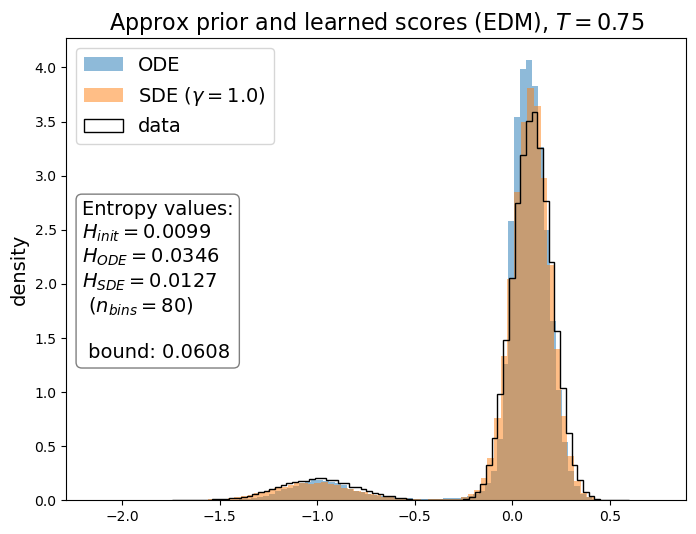

In [71]:
plot_figure(ode_samples, sde_samples, data, nsamples, nsteps, gamma, initial_time, datatype = datatype,
            nbins=nbins, bound=bound1d,
            initial_entropy=exact_initial_entropy,
            title=f'Approx prior and learned scores ({process.upper()})', figname=f'{prior}-learned-silu5-{process}-delta1d')

Inverse entropy

C:\Users\bepsc\AppData\Local\Temp\ipykernel_20328\499128227.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma*scale)


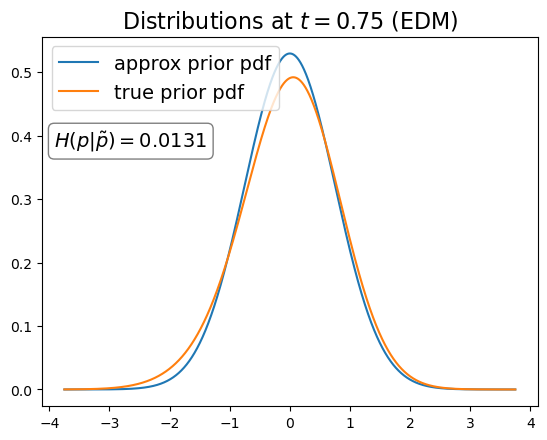

In [72]:
# Compute initial inverse entropy

sigma = scheduler.scheduler_fns.noise_fn(initial_time_)
xlim = 5*sigma
inv_initial_entropy = analytical_initial_entropy(dataset, initial_time, scheduler=scheduler, plot=True, xlim=xlim, process=process, inverseH=True)

In [73]:
# compute inverse bound

if exact_prior:
    inv_initial_entropy = 0

inv_bound, score_error_p = compute_inv_bound(inv_initial_entropy, forw_sde_his)

inv_ode_entropy, inv_sde_entropy = approx_entropy(ode_samples, sde_samples, diffused_data, nbins=100, inverseH=True)

print(f'Initial entropy: {inv_initial_entropy:.7f}')
print(f'ODE entropy: {inv_ode_entropy:.7f}')
print(f'SDE entropy: {inv_sde_entropy:.7f}')
print(f'Inverse bound: {inv_bound:.7f}')

Initial entropy: 0.0130602
ODE entropy: 0.0363294
SDE entropy: 0.0078275
Inverse bound: 0.0685728


In [74]:
# compute inverse-bound history

inv_bound_history = []
for step_final in range(initial_step, nsteps):
    print(f'step={step_final}')
    inv_bound, _ = compute_inv_bound(inv_initial_entropy, forw_sde_his, step_final=step_final)
    inv_bound_history.append(inv_bound)
inv_bound_history2 = inv_bound_history.copy()
inv_bound_history2.append(inv_bound_history[-1])

step=219
step=220
step=221
step=222
step=223
step=224
step=225
step=226
step=227
step=228
step=229
step=230
step=231
step=232
step=233
step=234
step=235
step=236
step=237
step=238
step=239
step=240
step=241
step=242
step=243
step=244
step=245
step=246
step=247
step=248
step=249
step=250
step=251
step=252
step=253
step=254
step=255
step=256
step=257
step=258
step=259
step=260
step=261
step=262
step=263
step=264
step=265
step=266
step=267
step=268
step=269
step=270
step=271
step=272
step=273
step=274
step=275
step=276
step=277
step=278
step=279
step=280
step=281
step=282
step=283
step=284
step=285
step=286
step=287
step=288
step=289
step=290
step=291
step=292
step=293
step=294
step=295
step=296
step=297
step=298
step=299
step=300
step=301
step=302
step=303
step=304
step=305
step=306
step=307
step=308
step=309
step=310
step=311
step=312
step=313
step=314
step=315
step=316
step=317
step=318
step=319
step=320
step=321
step=322
step=323
step=324
step=325
step=326
step=327
step=328
step=329
s

In [ ]:
# # save

# path = os.path.dirname(checkpointpath)
# path = os.path.dirname(path)
# path = os.path.join(path, 'saved_samples')
# torch.save(inv_bound_history2, os.path.join(path, f'inv_bound_history-{prior}-{process}'))

In [75]:
nbins = 50
inv_ode_entropies, inv_sde_entropies = compute_entropy_evolution(
    ode_history, sde_history, forw_sde_his, time2, nbins=nbins, inverseH=True)

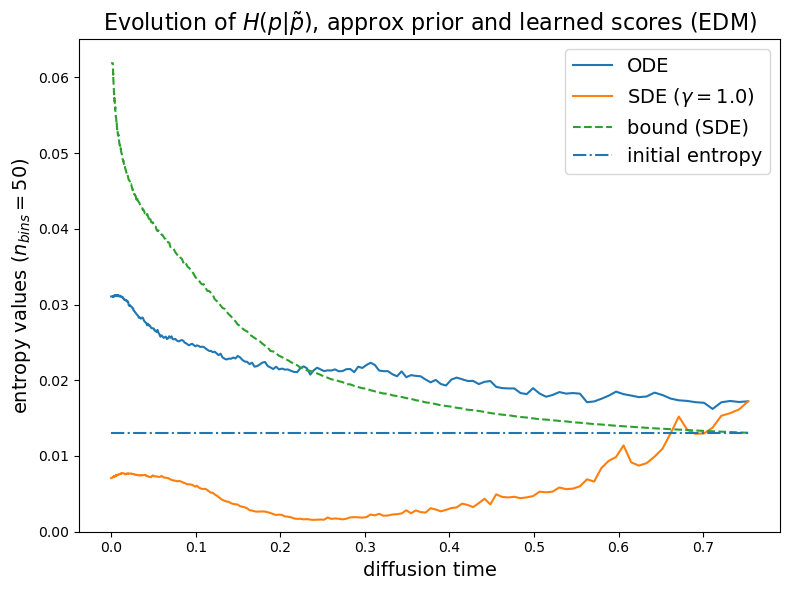

In [85]:
plot_entropy_evolution(inv_ode_entropies, inv_sde_entropies, time2, nsamples, gamma, initial_time, nsteps, datatype,
                       nbins=nbins, bound_history=inv_bound_history2, invH=True,
                       initial_entropy=inv_initial_entropy,
                       title=f'Evolution of $H(p|\~p)$, approx prior and learned scores ({process.upper()})',
                       figname=f'entropy_evolution-{prior}-learned-silu5-{process}-invH',
                       x_logscale=False, y_logscale=False, ylim=0.065)

Generate gamma grid for multiple $[S_{min}, S_{max}]$

In [38]:
def generate_multiple_interval(gamma, nsteps, nsamples, dataset, datatype, initial_time, tmin,
                               noisescheduler, module, process, initial_p, exact_p,
                               return_history=False, use_exact_prior=False,
                               checkpoint=None, interval_grid=None, alpha=0.1, ngrid=10):
    if interval_grid is None:
        S_values = custom_spacing(tmin, initial_time, ngrid, alpha=alpha)
        interval_grid = list(itertools.product(S_values, S_values))
        print(interval_grid)
    sample_histories = []
    for smin, smax in interval_grid:
        if smin < smax:
            print(f'interval=[{smin}, {smax}]')
            samples_history = generate_samples(
                initial_step, gamma, nsteps, nsamples, dataset, datatype, initial_p, exact_p, module=module, sample_type='sde',
                checkpoint=checkpoint, interval=[smin, smax],
                use_exact_prior=use_exact_prior, noisescheduler=noisescheduler,
                save_samples=False)
        else:
            samples_history = None
        sample_histories.append(samples_history)
    
    # save
    if module is not None:
        if checkpoint is None:
            raise ValueError('Checkpoint is required')
        path = pathlib.Path(checkpoint).parent.parent / 'saved_samples'
    else:
        path = path_from_datatype(datatype)
    path.mkdir(exist_ok=True)
    
    filename = f'trained-nsamples={nsamples:.0e}-nsteps={nsteps}-T={initial_time:.3f}'
    if use_exact_prior:
        filename = 'exact_prior-' + filename
    else:
        filename = 'indep_prior-' + filename
    filename += f'-g={gamma}-interv_grid-T={initial_time:.2f}-{process}'
    if return_history:
        filename += '-his'
    torch.save(sample_histories, path / filename)
    return sample_histories

In [39]:
# Define parameters
process = 'edm'

if process == 'edm':
    scheduler = diffsci.models.EDMScheduler(sigma_max=10.0)
    initial_time=0.75
elif process == 'vp':
    scheduler = VPScheduler()
    initial_time=0.21
elif process == 've':
    scheduler = VEScheduler()
    initial_time=0.55
else:
    raise ValueError('Invalid process')

initial_time_ = torch.tensor(initial_time)
nsteps = 500
gamma = 2
nsamples = 100000

initial_step = scheduler.step_from_time(t=initial_time_, n=nsteps)
time = scheduler.create_steps(nsteps+1)
initial_time = time[initial_step].item()
print(f'Initial step: {initial_step}')
print(f'Initial_time: {initial_time}')

Initial step: 219
Initial_time: 0.7530995011329651


In [40]:
# Generate data for comparison
tmin = time[-1]
sigma_min = scheduler.scheduler_fns.noise_fn(tmin)
scale_min = scheduler.scheduler_fns.scaling_fn(tmin)
noise = torch.randn_like(gaussian_samples2) * sigma_min * scale_min
diffused_gdata = scale_min * gaussian_samples2 + noise
diffused_gdata = diffused_gdata.squeeze(-1)
diffused_gdata2 = scale_min * gaussian_samples2 + noise
diffused_gdata2 = diffused_gdata2.squeeze(-1)

diffused_data = diffused_gdata2

In [41]:
exact_prior = False

prior = 'approx_prior'
if exact_prior:
    exact_initial_entropy = 0
    prior = 'exact_prior'

In [61]:
# # generate sample histories for different intervals

# sample_histories = generate_multiple_interval(
#     gamma, nsteps, nsamples, dataset, datatype, initial_time, tmin, scheduler, module, process, initial_p, exact_p,
#     return_history=True, use_exact_prior=exact_prior, checkpoint=checkpointpath, alpha=0.3)

In [ ]:
# # load saved samples

# path = r"C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\savedmodels\experimental\mixt_gauss2_silu-[100, 100, 100]-lr=0.0004-bs=16-nsamples=100000\saved_samples\indep_prior-trained-nsamples=1e+05-nsteps=500-T=0.753-g=2-interv_grid-T=0.75-edm-his"
# sample_histories = torch.load(path)

In [44]:
samples = [sample_history[-1] if sample_history is not None else None for sample_history in sample_histories]

In [46]:
def plot_general_colormap(samples, ode_samples, diffused_data, datatype, initial_time, tmin,
                          nbins=50, ngrid=10, alpha=0.1, title=None, figname=None, plot_sigma=False):

    sde_entropies = []
    for sample in samples:
        if sample is None:
            sde_entropy = np.nan
        else:
            sample = sample.squeeze(-1)
            sde_entropy = approx_entropy1(sample, diffused_data, nbins=nbins)
        sde_entropies.append(sde_entropy)
    ode_entropy = approx_entropy1(ode_samples, diffused_data, nbins=nbins)
    print(sde_entropies)

    # plot a ngridxngrid colormap/colortable of the entropies
    sde_entropies = torch.tensor(sde_entropies)
    sde_entropies = sde_entropies.reshape(ngrid, ngrid)
    for i in range(ngrid):
            if torch.isnan(sde_entropies[i, i]):
                sde_entropies[i, i] = ode_entropy
            else:
                print(f'for i={i}, entropy={sde_entropies[i, i]:.4f}')
                raise ValueError('Entropy should be nan in the diagonal')
            
    sde_entropies = torch.flip(sde_entropies, dims=(0,))
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    im = ax.imshow(sde_entropies, cmap='viridis')

    # We want to show all ticks...
    ax.set_xticks(np.arange(ngrid))
    ax.set_yticks(np.arange(ngrid))
    # ... and label them with the respective list entries
    x = custom_spacing(tmin, initial_time, ngrid, alpha=alpha)
    if plot_sigma:
        x = [scheduler.scheduler_fns.noise_fn(t) for t in x]
    x = [f'{v:.3f}' for v in x]
    # x = x[::-1]
    y = x[::-1]
    ax.set_xticklabels(x)
    ax.set_yticklabels(y)
    if plot_sigma:
        ax.set_xlabel('$\sigma(S_{max})$', fontsize=14)
        ax.set_ylabel('$\sigma(S_{min})$', fontsize=14)
    else:
        ax.set_xlabel('$S_{max}$', fontsize=14)
        ax.set_ylabel('$S_{min}$', fontsize=14)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(ngrid):
        for j in range(ngrid):
            text = ax.text(j, i, f'{sde_entropies[i, j]:.3f}',
                           ha="center", va="center", color="w",
                           fontsize=12)
    # show colorbar
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('entropy', fontsize=12)
    
    ax.set_title(f'{title}, T={initial_time:.2f}', fontsize=16, pad=20)
    fig.tight_layout()
    path = path_from_datatype(datatype, figure=True)
    path.mkdir(exist_ok=True)
    if figname is not None:
        fig.savefig(path / f'{figname}.png')
    plt.show()

    return sde_entropies

In [47]:
# load the pure ODE
ode_path = r"C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\savedmodels\experimental\mixt_gauss2_silu-[100, 100, 100]-lr=0.0004-bs=16-nsamples=100000\saved_samples\ode-indep_prior-tr-nsamples=1e+05-nsteps=500-T=0.753-his-EDM"
ode_history = torch.load(ode_path)
ode_samples = ode_history[-1]

In [48]:
nbins = 50

[nan, 0.032795820202294906, 0.03267697875670427, 0.027582805965590273, 0.01855454438983195, 0.011051057551464337, 0.01142313806916421, 0.012554981049329013, 0.013161852885224258, 0.014879676630678365, nan, nan, 0.03220470572735075, 0.02815839340548036, 0.01888222376096751, 0.010680089641773345, 0.011354232363147056, 0.015602910209922816, 0.012636330859471521, 0.013491441123469937, nan, nan, nan, 0.029665641081464994, 0.018861099357186682, 0.010611781588652142, 0.01177150564149061, 0.014016215110588247, 0.013058949931416576, 0.013861791016711056, nan, nan, nan, nan, 0.02059490975380759, 0.010974597696678764, 0.011258859373443522, 0.015319503354092556, 0.013929614285820444, 0.011859272205469118, nan, nan, nan, nan, nan, 0.011905795486567125, 0.01250215737799592, 0.015633490400025884, 0.012975013993676511, 0.014938864785379837, nan, nan, nan, nan, nan, nan, 0.01573302075731806, 0.01699504649706904, 0.016901270296219493, 0.01968980609796579, nan, nan, nan, nan, nan, nan, nan, 0.01939716461

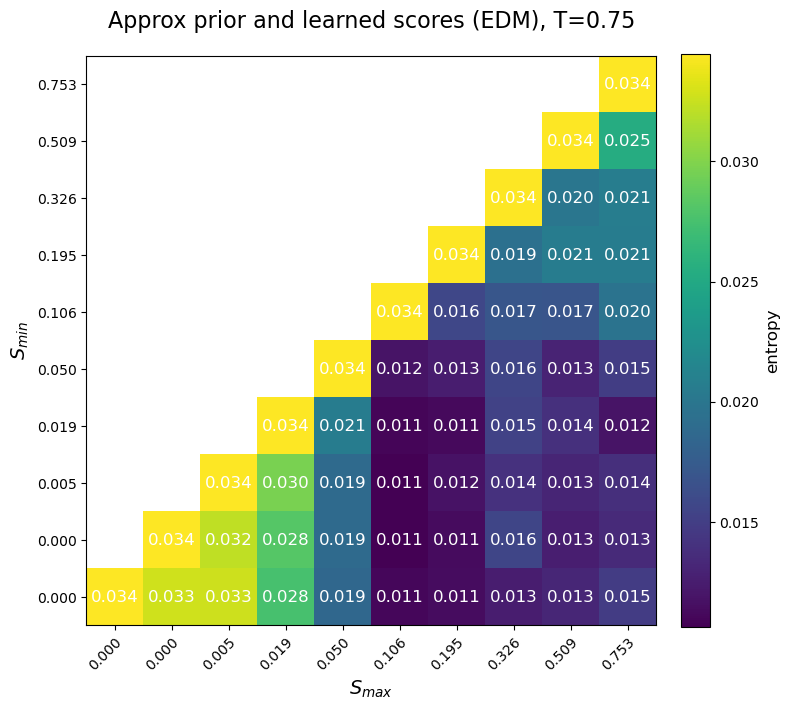

tensor([[   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
         0.0345],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan, 0.0345,
         0.0254],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan, 0.0345, 0.0200,
         0.0207],
        [   nan,    nan,    nan,    nan,    nan,    nan, 0.0345, 0.0194, 0.0207,
         0.0206],
        [   nan,    nan,    nan,    nan,    nan, 0.0345, 0.0157, 0.0170, 0.0169,
         0.0197],
        [   nan,    nan,    nan,    nan, 0.0345, 0.0119, 0.0125, 0.0156, 0.0130,
         0.0149],
        [   nan,    nan,    nan, 0.0345, 0.0206, 0.0110, 0.0113, 0.0153, 0.0139,
         0.0119],
        [   nan,    nan, 0.0345, 0.0297, 0.0189, 0.0106, 0.0118, 0.0140, 0.0131,
         0.0139],
        [   nan, 0.0345, 0.0322, 0.0282, 0.0189, 0.0107, 0.0114, 0.0156, 0.0126,
         0.0135],
        [0.0345, 0.0328, 0.0327, 0.0276, 0.0186, 0.0111, 0.0114, 0.0126, 0.0132,
         0.0149]], dtype=tor

In [49]:
plot_general_colormap(samples, ode_samples, diffused_data, datatype, initial_time, tmin, plot_sigma=False,
                      nbins=nbins, ngrid=10, alpha=0.3, title=f'Approx prior and learned scores ({process.upper()})',
                      figname=f'general_colormap-{prior}-learned-silu5-T={initial_time:.2f}-{process}')

In [ ]:
sde_history_best = sample_histories[5]
sde_history = sample_histories[9]

In [52]:
# Generate data for comparison
tmin = time[-2]
print(f'Final time: {tmin}')
sigma_min = scheduler.scheduler_fns.noise_fn(tmin)
scale_min = scheduler.scheduler_fns.scaling_fn(tmin)
noise = torch.randn_like(gaussian_samples2) * sigma_min * scale_min

diffused_gdata2 = scale_min * gaussian_samples2 + noise
diffused_data = diffused_gdata2

Final time: 0.0019999996293336153


In [53]:
data = gaussian_samples2
# temporarily change gamma to 1
scheduler.langevin_const = 1

history_steps = nsteps+1-initial_step
forw_sde_history = scheduler.propagate_forward(diffused_data, dataset.gradlogprob, nsteps, record_history=True, stochastic=True)
forw_sde_history = forw_sde_history.cpu()
forw_sde_his = forw_sde_history[:history_steps].squeeze(-1)
forw_sde_his = forw_sde_his.flip(0)

# unchange gamma
scheduler.langevin_const = gamma

forw_sde_his.shape, sde_history_best.shape

(torch.Size([282, 100000]), torch.Size([282, 100000]))

In [54]:
time2 = time[initial_step:]

In [55]:
def approx_entropy_multiple(samples, samples_ref, epsilon=1e-12, nbins=100, mean = True):
    entropies_ = []
    for nb in range(nbins-20, nbins):
        if nb%4 == 0:
            continue
        entropies = []
        mins = [sample.min() for sample in samples]
        maxs = [sample.max() for sample in samples]
        min_value = min(mins+[samples_ref.min()])
        max_value = max(maxs+[samples_ref.max()])
        dist = []
        bins = np.linspace(min_value, max_value, nb)
        for sample in samples + [samples_ref]:
            hist = np.histogram(sample, bins=bins, density=True)[0]
            dist.append(hist+epsilon)
        for i in range(len(samples)):
            entrop = entropy(dist[i], dist[-1])
            entropies.append(entrop)
        entropies_.append(entropies)
    entropies_ = torch.tensor(entropies_)
    if mean:
        final_entropies = torch.mean(entropies_, dim=0)
    else:
        final_entropies = torch.min(entropies_, dim=0).values
    return final_entropies

In [56]:
def multiple_entropy_evolution(histories, diffused_history, time, nbins=100, mean=True):
    # compute statistics
    entropies_histories = []
    nsteps = time.shape[0]
    for i in range(nsteps):
        entropies = approx_entropy_multiple([history[i] for history in histories], diffused_history[i], nbins=nbins, mean=mean)
        entropies_histories.append(entropies)
    entropies_histories = torch.stack(entropies_histories)
    print(torch.tensor(entropies_histories).shape)
    return entropies_histories

def plot_multiple_entropy_evolution(entropies_histories, names, time, nsamples, gamma, initial_time,
                           datatype, interval=None, initial_entropy=None, bound_history=None, nbins=100, title='approximate prior and analytic scores',
                           figname='multiple_entropy_evolution-approx_prior-analytic',
                           x_logscale=False, y_logscale=False, ylim=None, fontsize=14, plot_sigma=False):
    fig = plt.figure(figsize=(8, 6))
    if plot_sigma:
        time = scheduler.scheduler_fns.noise_fn(time)
    for i in range(len(names)):
        plt.plot(time, entropies_histories[:, i], label=names[i])
    if bound_history is not None:
        plt.plot(time, bound_history, label='bound (SDE)', linestyle='--')
    if initial_entropy is not None:
        plt.hlines(initial_entropy, 0, time[0], label='initial entropy', linestyle='-.')
    if plot_sigma:
        plt.xlabel("$\sigma(t)$", fontsize=fontsize)
    else:
        plt.xlabel("diffusion time", fontsize=fontsize)
    plt.ylabel(f"entropy values ($n_{{bins}}={nbins}$)", fontsize=fontsize)
    if x_logscale:
        plt.xscale('log')
    if y_logscale:
        plt.yscale('log')
    if ylim is not None:
        plt.ylim(0, ylim)
    plt.legend(fontsize=fontsize)
    plt.title('Entropy evolution,'+ title, fontsize=fontsize+2)
    plt.tight_layout()

    # save figure
    path = path_from_datatype(datatype, figure=True)
    path.mkdir(exist_ok=True)
    figure_name = figname + f'-nsamples={nsamples:.0e}-nsteps={nsteps}-T={initial_time:.3f}-g={gamma}'
    if interval is not None:
        figure_name += f'-{interval}'
    if x_logscale:
        figure_name += '-xlog'
    if y_logscale:
        figure_name += '-ylog'
    figure_name +='.png'
    fig.savefig(path / figure_name)
    return None

In [57]:
nbins = 50

histories = [sde_history_best, sde_history, ode_history]
entropies_histories = multiple_entropy_evolution(histories, forw_sde_his, time2, nbins=nbins, mean=True)

torch.Size([282, 3])


C:\Users\bepsc\AppData\Local\Temp\ipykernel_49960\150812659.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(entropies_histories).shape)


C:\Users\bepsc\AppData\Local\Temp\ipykernel_49960\499128227.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma*scale)


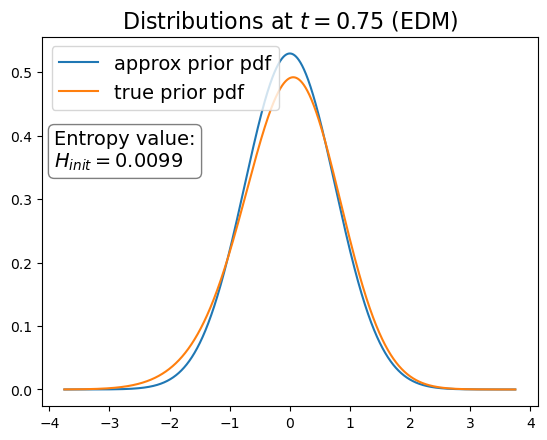

In [58]:
if exact_prior:
    exact_initial_entropy = 0
else:
    sigma = scheduler.scheduler_fns.noise_fn(initial_time_)
    xlim = 5*sigma
    exact_initial_entropy = analytical_initial_entropy(dataset, initial_time, scheduler=scheduler, plot=True, xlim=xlim,
                                                   process=process)

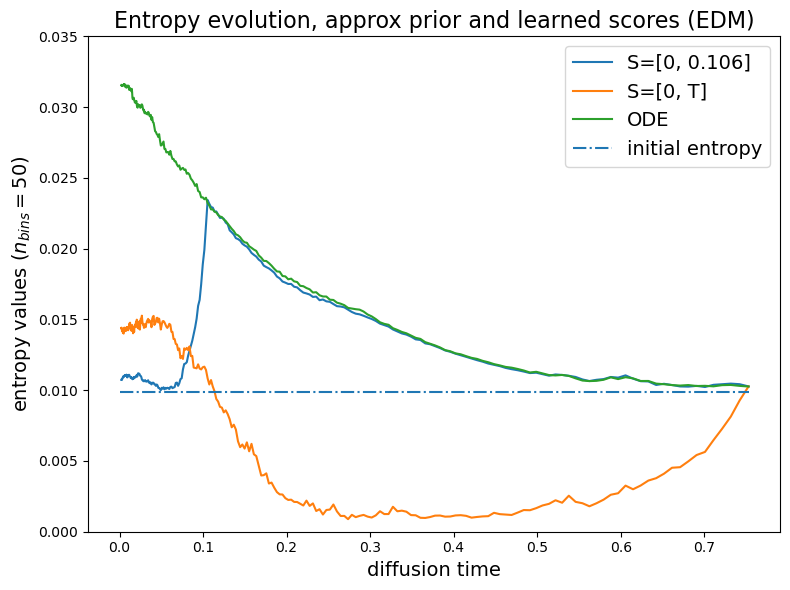

In [60]:
smin = 0.019
smax = 0.106

names = [f'S=[0, {smax}]','S=[0, T]', 'ODE']
plot_multiple_entropy_evolution(entropies_histories[:-1], names, time2[:-1], nsamples, gamma, initial_time,
                           datatype, interval='optimal interval',
                           initial_entropy=exact_initial_entropy,
                           nbins=nbins, title=f' approx prior and learned scores ({process.upper()})',
                           figname=f'multiple_entropy_evolution-{prior}-learned-silu5-opt-interv-{process}',
                           x_logscale=False, y_logscale=False, ylim=0.035, plot_sigma=False)